# OMAE2020-4810, main notebook

This notebook is released in relation to OMAE2020-4810 *CONTINUOUS DRILLING SENSOR DATA RECONSTRUCTION ANDPREDICTION VIA RECURRENT NEURAL NETWORKS* publication. Source code is published on CC BY-NC-SA 4.0 license.

This is the main notebook used for the published study

Andrzej Tunkiel

University of Stavanger

Let's start off by defining a seed to make the results reproducible. We are also filtering some warnings which mostly relate to methods that are being depreciated in TensorFlow and/or Keras.

This notebook was tested with Keras 2.2.5 and TensorFlow 1.14.0.

In [1]:
from numpy.random import seed
seed(0)
from tensorflow import set_random_seed
set_random_seed(0)

import warnings
warnings.filterwarnings('ignore')

C:\Users\2921228\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\2921228\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\2921228\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint

Cell with all relevant imports.

In [2]:
%matplotlib inline
from pylab import rcParams
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
from pandas import datetime
import numpy as np
from pandas.plotting import autocorrelation_plot
import statsmodels as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf
from statsmodels.tsa.statespace import sarimax

from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers.core import Reshape
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.utils import plot_model
from keras.layers import Dense, Dropout, Input, concatenate, Add
from keras.models import load_model

from keras import Model, Input
from keras.layers import (LSTM, Dense, Activation, BatchNormalization, 
                      Dropout, Bidirectional, Add, Flatten, GaussianNoise)

from keras.layers import Dense, LSTM, GlobalMaxPooling1D, MaxPooling1D

from keras import optimizers

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.kernel_ridge import KernelRidge
from sklearn import svm
from sklearn import linear_model
from sklearn.neighbors import  RadiusNeighborsRegressor
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Setting up correct figure size.

In [3]:
rcParams['figure.figsize'] = 11,5

Definition of some functions that will be used later. Refer to comments for details.

In [4]:
#this function uses the RadiusNeighborsRegressor to unify sampling of all the parameters.

def sampling_fix(df,name,start,stop,radius,medianFilter,plot):
    #Filter dataset based on depth range
    df = df[(df['Measured Depth m'] > start) & (df['Measured Depth m'] < stop) ]
    #remove NaNs from dataset
    df = df[np.isfinite(df[name])]
    X = df['Measured Depth m']
    
    #reshape the depth to matcch regressor requirements
    X = X.values.reshape(X.shape[0],1)
    
    #define regressor with provided radius
    reg = RadiusNeighborsRegressor(radius=radius, weights='uniform')
    
    #apply median filter with back filling (to remove NaNs at the beginning of dataset)
    y = df[name].rolling(medianFilter).median().bfill()
    
    #fit regressor
    reg.fit(X, y)
    
    #check if plotting was required or should the model be returned
    if plot == 0:
        return reg
    else:
        #plot the chart. Original data is plotted as well as the regression data.
        plt.scatter(X,y, label=name)
        plt.plot(X, reg.predict(X),c='r',label="prediction")
        plt.legend()
        plt.show()


#prepareinput will convert the data to a format that's usable by recurrent neural network. Essentially 
#what is does it converts 1D array to 2D array 
def prepareinput(data, memory_local):
    memory = memory_local
    stack = []
    for i in range(memory):
        stack.append(np.roll(data, -i))

    X_temp = np.hstack(stack)


    X_min = X_temp[:,0]
    X = X_temp-X_min[:,np.newaxis] #here the function will move the values to zero, used for inclination data processing
    return X


#same as above, but ommits the movement to zero.
def prepareinput_nozero(data, memory_local, predictions):
    memory = memory_local
    stack = []
    for i in range(memory+predictions):
        stack.append(np.roll(data, -i))

    X = np.hstack(stack) 
    return X


#again, similar processing, but for output.
def prepareoutput(data, memory_local, predictions):
    memory = memory_local
    stack = []
    for i in range(memory, memory+predictions):
        stack.append(np.roll(data, -i))

    X = np.hstack(stack)
    return X


#this function was used to inspect results. In the current setup it is run only once when the 
#training is complete. 
def mymanyplots(epoch, data, model):
    
    #for brevity most of variables needed to plot the plots are bundled in a list, that is deconstructed below
    [X1, X2, X3, X4, y, X1_train,X_train, X_test, X1_test, border1, border2, y_train, y_test, memory, y_temp, predictions] = data

    Xtrain = model.predict(X_train)
    Xtest = model.predict(X_test)
    
    rcParams['figure.figsize'] = 11, 5

    

    for i in range(1):  #while this does not do anything right now, during development it was set at range(5) and
                        #more. Note that there is a random sample that's plotted, hence each loop will generate 
                        #different charts. Useful during development.
                        #This function plots Training dataset.
        shape = (7,1)
        fig = plt.figure()
        fig.tight_layout()
        fig.subplots_adjust(hspace = 1)
        ax1 = plt.subplot2grid(shape, (0,0), rowspan=4)    
        ax2 = plt.subplot2grid(shape, (4,0), sharex=ax1)
        ax3 = plt.subplot2grid(shape, (5,0), sharex=ax1)    
        ax4 = plt.subplot2grid(shape, (6,0), sharex=ax1)
        
        for ax in fig.axes:
            plt.setp(ax.get_xticklabels(), visible=False)

        #regrettably some hard coding was done.
        known_attributes = ['Average Surface Torque kN.m', 'Average Rotary Speed rpm', 'Rate of Penetration m/h']

        i=0
        for axe in fig.axes:
            if i == 0:
                tr = np.random.randint(0, border1)
                axe.plot(np.arange(memory,memory+predictions,1),y_train[tr],linewidth=5,alpha=0.5,c='b', label='training input')
                axe.plot(np.arange(0,memory,1),X1_train[tr], linewidth=5,alpha=0.5, c='g' , label="training expected")
                axe.plot(np.arange(memory,memory+predictions,1),Xtrain[tr],c='r', label='training predicted')
                axe.set_title('Training results')
                axe.set_facecolor('xkcd:light blue')
                axe.legend()

            else:

                axe.plot(np.arange(0,memory+predictions,1),X_train[1][tr,:,i-1],label=known_attributes[i-1]) 
                axe.set_facecolor('xkcd:ivory')
                axe.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
               ncol=2, mode="expand", borderaxespad=0.)
            i = i + 1
        plt.show()

    for i in range(3): #similar to previous loop, but with range(3). This one plots the test dataset.
        shape = (7,1)
        fig = plt.figure()
        fig.tight_layout()
        fig.subplots_adjust(hspace = 1)
        ax1 = plt.subplot2grid(shape, (0,0), rowspan=4)    
        ax2 = plt.subplot2grid(shape, (4,0), sharex=ax1)
        ax3 = plt.subplot2grid(shape, (5,0), sharex=ax1)    
        ax4 = plt.subplot2grid(shape, (6,0), sharex=ax1)
        
        for ax in fig.axes:
            plt.setp(ax.get_xticklabels(), visible=False)

        known_attributes = ['Average Surface Torque kN.m', 'Average Rotary Speed rpm', 'Rate of Penetration m/h']

        i=0
        for axe in fig.axes:
            if i == 0:
                tr = np.random.randint(0, border2 - border1)
                axe.plot(np.arange(memory,memory+predictions,1),y_test[tr],linewidth=5,alpha=0.5,c='b', label='testing input')
                axe.plot(np.arange(0,memory,1),X1_test[tr], linewidth=5,alpha=0.5, c='g' , label="testing expected")
                axe.plot(np.arange(memory,memory+predictions,1),Xtest[tr],c='r', label='testing predicted')
                axe.set_title('Testing results')
                axe.set_facecolor('xkcd:light grey')
                axe.legend()

            else:

                axe.plot(np.arange(0,memory+predictions,1),X_test[1][tr,:,i-1],label=known_attributes[i-1]) 
                axe.set_facecolor('xkcd:ivory')
                axe.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
               ncol=2, mode="expand", borderaxespad=0.)
            i = i + 1
        plt.show()

Main function that trains the model.

It is called hyperparameter as it can receive all data parametrically which is useful for hyperparameter tuning.

In [5]:
def hyperparameter (matrix):
    
    [start, stop, inc_layer1,inc_layer2,data_layer1,data_layer2,dense_layer,range_max,memory, predictions, drop1, drop2] = matrix
    drop1 = drop1/100
    drop2 = drop2/100
    inc_layer2 = inc_layer2/1000

    df = pd.read_csv('F9ADepth.csv') #parsed WITSML file from Volve dataset (Equinor, CC BY-NC-SA 4.0)

    start = start
    stop = stop
    step = 0.230876

    X = np.arange(start,stop,step)
    X = X.reshape(X.shape[0],1)



    %matplotlib inline
    rcParams['figure.figsize'] = 10, 5

    X = np.arange(start,stop,step)
    X = X.reshape(X.shape[0],1)

    #hard coded variables to pick up from the dataframe.
    my_data1 = sampling_fix(df, 'MWD Continuous Inclination dega',start,stop,1.7,1,0).predict(X)
    my_data2 = sampling_fix(df, 'Average Surface Torque kN.m',start,stop,1.7,3,0).predict(X)
    my_data3 = sampling_fix(df, 'Average Rotary Speed rpm',start,stop,1.7,3,0).predict(X)
    my_data4 = sampling_fix(df, 'Rate of Penetration m/h',start,stop,0.5,1,0).predict(X)

    data_array = np.asarray([my_data1, my_data2, my_data3, my_data4])


    my_data1 = my_data1[:,np.newaxis]
    my_data2 = my_data2[:,np.newaxis]
    my_data3 = my_data3[:,np.newaxis]
    my_data4 = my_data4[:,np.newaxis]


    temp_data1 = pd.DataFrame(my_data1.flatten())

    #lines below are responsible for scaling the inclination. Scaler has to run on data before it gets
    #transformed into RNN-compatible samples, yet we want RNN-compatible samples to be from 0 to
    #approximately 1. This takes care of it.
    range1 = temp_data1[0].diff(memory+predictions)
    
    
    range2 = np.amax(range1)

    
    
    scaler1 = MinMaxScaler(feature_range=(0,my_data1[-1]/range2))
    scaler2 = MinMaxScaler()
    scaler3 = MinMaxScaler()
    scaler4 = MinMaxScaler()



    my_data1 = scaler1.fit_transform(my_data1)
    my_data2 = scaler2.fit_transform(my_data2)
    my_data3 = scaler3.fit_transform(my_data3)
    my_data4 = scaler4.fit_transform(my_data4)


    X1 = prepareinput(my_data1, memory)


    X2 = prepareinput_nozero(my_data2,memory, predictions)
    X3 = prepareinput_nozero(my_data3,memory, predictions)
    X4 = prepareinput_nozero(my_data4,memory, predictions)


    y_temp = prepareoutput(my_data1, memory, predictions)

    
    stack = []
    for i in range(memory):
        stack.append(np.roll(my_data1, -i))

    X_temp = np.hstack(stack)



    X_min_for_y = X_temp[:,0]

    y = y_temp - X_min_for_y[:,np.newaxis]


    
    data_length = len(my_data1)-memory-predictions #checking the usable length of data

    testing_cutoff = 0.80   #80 pecent for training, rest for validation. Note that this function receives
                            #Training + Validation data only. It does not get the whole dataset (Testing is not here)


    border1 = int((data_length)*testing_cutoff)
    border2 = data_length



    #below is train - validation split. Note that _test variables here really belong to validation dataset.

    X1_train =  X1[:border1]
    X1_test = X1[border1:border2]

    X2_train =  X2[:border1]
    X2_test = X2[border1:border2]

    X3_train =  X3[:border1]
    X3_test = X3[border1:border2]

    X4_train =  X4[:border1]
    X4_test = X4[border1:border2]


    y_train,y_test = y[:border1],y[border1:border2]

    X1_train = X1_train.reshape((X1_train.shape[0],X1_train.shape[1],1))
    X1_test = X1_test.reshape((X1_test.shape[0],X1_test.shape[1],1))

    X2_train = X2_train.reshape((X2_train.shape[0],X2_train.shape[1],1))
    X2_test = X2_test.reshape((X2_test.shape[0],X2_test.shape[1],1))

    X3_train = X3_train.reshape((X3_train.shape[0],X3_train.shape[1],1))
    X3_test = X3_test.reshape((X3_test.shape[0],X3_test.shape[1],1))

    X4_train = X4_train.reshape((X4_train.shape[0],X4_train.shape[1],1))
    X4_test = X4_test.reshape((X4_test.shape[0],X4_test.shape[1],1))

    X_train_con = np.concatenate((X2_train, X3_train, X4_train), axis=2)
    X_test_con  = np.concatenate((X2_test,  X3_test,  X4_test),  axis=2)

    X_train = [X1_train, X_train_con]
    X_test = [X1_test, X_test_con]




    from keras.layers import Dense, LSTM, GlobalMaxPooling1D, MaxPooling1D


    #defining the neural network architecture with x1 being RNN, x2 MLP.

    input1 = Input(shape=(memory,1))
    input2 = Input(shape=(memory + predictions,3))



    x1 = GaussianNoise(inc_layer2, input_shape=(memory,1))(input1)
    
    x1 = CuDNNGRU(units=256, kernel_initializer = 'glorot_uniform', recurrent_initializer='orthogonal',
          bias_initializer='zeros', kernel_regularizer='l2', recurrent_regularizer=None,
          bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
          recurrent_constraint=None, bias_constraint=None, return_sequences=False,
          return_state=False, stateful=False)(x1)
    x1 = Dropout(drop1)(x1)
   
    x1 = Model(inputs=input1, outputs=x1)

    x2 = Dense(data_layer1, input_shape=(memory+predictions,3))(input2)
    x2 = Dropout(drop2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(data_layer2)(x2)
    x2 = Model(inputs=input2, outputs=x2)



    #combine the output of branches
    combined = concatenate([x1.output, x2.output])

    #add output layers
    z = Dense(dense_layer, activation="relu")(combined)
    z = Dense(predictions, activation="linear")(z)





    #define the model
    model = Model(inputs=[x1.input, x2.input], outputs=z)

    

    model.compile(optimizer='adam',loss='mean_squared_error') 
    #plot_model(model, show_shapes=True, expand_nested=True) #commented out plotting of the model.

    #some callbacks are defined to monitor validation loss and ensure early stopping, as well as
    #simple dot printing to keep an eye on the progress.
    
    from keras.callbacks import Callback
    class PlotResuls(Callback):
        def on_train_begin(self, logs={}):
            self.i = 0
            self.x = []
            self.losses = []
            self.val_losses = []

            self.fig = plt.figure()

            self.logs = []

        def on_epoch_end(self, epoch, logs={}):
            self.logs.append(logs)
            self.x.append(self.i)
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            self.i += 1

            print (".", end = '')
            
            if (epoch % 14999 == 0) & (epoch > 0):  #this can be used for intermittent validation loss plotting
                                                    #currently effectively disabled, as training ends under 200 epochs.
                print(epoch)
                rcParams['figure.figsize'] = 11, 3
                plt.plot(self.x, np.log(self.losses), label="loss")
                plt.plot(self.x, np.log(self.val_losses), label="val_loss")
                plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)
                plt.title("Loss")
                plt.legend()
                plt.show();
                mymanyplots(epoch, data, model)

    

    
    data = [X1, X2, X3, X4, y, X1_train,X_train, X_test, X1_test, border1, border2, y_train, y_test, memory, y_temp, predictions]
    plot_results = PlotResuls()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=0)
    
    history = model.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=5000, verbose=0, batch_size=32,callbacks=[plot_results, es, mc])
    
    plt.plot(np.log(history.history['loss']), label='loss')
    plt.plot(np.log(history.history['val_loss']), label='test')
    plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)
    plt.legend()
    plt.clf() 
    
    model = load_model('best_model.h5')
    mymanyplots(-1, data, model)

    #the function returns the best model, validation loss and scalers. Scalers are returned
    #since they will change with changing parameters (for example memory length or Train-Val-Test split)
    return model, np.log(model.evaluate(x= X_test, y=y_test)), scaler1, scaler2, scaler3, scaler4

Next cell was used for hyperparameter training. Now it is limited to just one set of hyperparameters, the same ones that were used in the paper

###





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

............................................................................................................................................................Epoch 00156: early stopping


<Figure size 720x360 with 0 Axes>

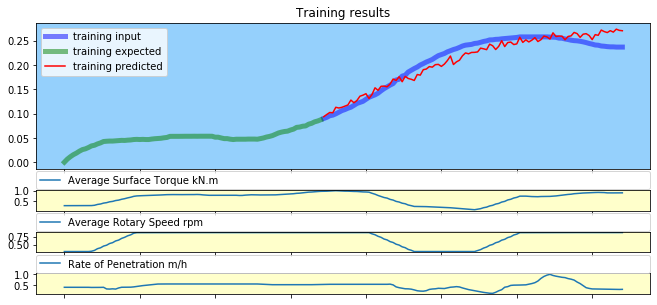

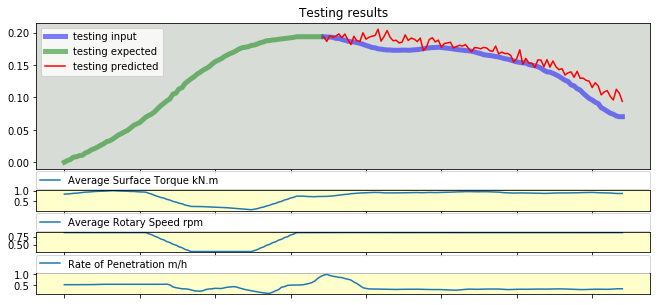

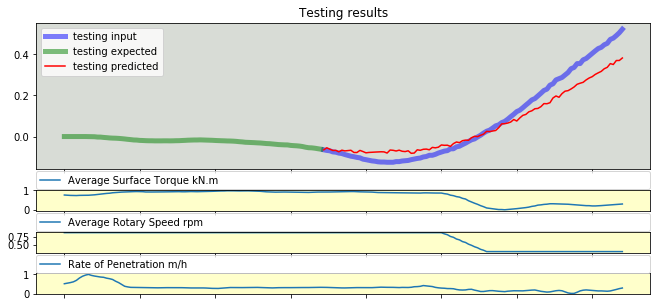

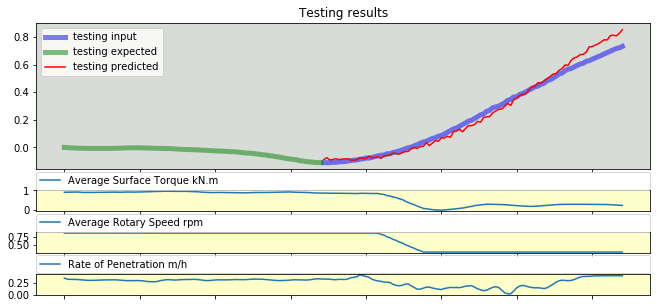

223/223 [==============================] - 0s 599us/step
[500 800 256  20   8   1 136   1  86 100  25  50]
-6.116369246889071


In [6]:
#Defining the section of the well, in meters

begin = 500 #start of training+validation
middle = 800 #end of training+validation, start of testing
end = 843 #end of testing

model_array = []
val_loss_array = []
hypers_array = []

def expandaxis (var):
    var = np.expand_dims(var, axis=1)
    return var

matrix_size = int(1)


start = np.full((matrix_size,), begin)
stop = np.full((matrix_size,), middle)

inc_layer1 = np.full((matrix_size,), 256) 

inc_layer2 = np.full((matrix_size,), 20) #gaussian noise now, divided by 1000.

data_layer1 = np.full((matrix_size,), 8) 
data_layer2 = np.full((matrix_size,), 1) 

dense_layer = np.full((matrix_size,), 136)  

range_max =np.full((matrix_size,), 1)  #DISABLED

memory =  np.full((matrix_size,), 86)  


predictions = np.full((matrix_size,), 100)

drop1 = np.full((matrix_size,), 25)
drop2 = np.full((matrix_size,), 50) 

#expand axis for stacking of sets of hyperparameters.

start = expandaxis(start)
stop = expandaxis(stop)
inc_layer1 = expandaxis (inc_layer1)

inc_layer2 = expandaxis (inc_layer2)

data_layer1 = expandaxis (data_layer1)
data_layer2 = expandaxis (data_layer2)

dense_layer = expandaxis (dense_layer)

range_max =expandaxis (range_max)

memory =  expandaxis (memory)

predictions = expandaxis(predictions)
drop1 = expandaxis(drop1)
drop2 = expandaxis(drop2)

hypers = np.hstack([start, stop, inc_layer1,inc_layer2,data_layer1,data_layer2,dense_layer, range_max, memory, predictions, drop1, drop2])

ID = np.random.randint(0,999999) #this is a random number used to record used hyperparameters and results.
                                    #hyperparameter tuning was done in a distributed manner with no way
                                    #of keeping track of logs. This, with high likelyhood, allowed us to generate
                                    #logs with unique name. Not good enough for production purposes, but enough 
                                    #for research

for i in hypers:
    print("###")
    model, val_loss, scaler1, scaler2, scaler3, scaler4 = hyperparameter(i)
    #model_array.append(model)
    val_loss_array.append(val_loss)
    hypers_array.append(i)
    print (i)
    print (val_loss)
    output = np.append(hypers_array, expandaxis(val_loss_array), axis=1)
    output = pd.DataFrame(output,columns=["start", "stop", "inc_layer1","inc_layer2","data_layer1","data_layer2","dense_layer"," range_max"," memory"," predictions","drop1","drop2", "val loss"])
    try:
        #print (output)
        output.to_csv(str(ID) + " LSTM 21 gauss.csv")
    except:
        print("File opened?")

Function below was very useful when hyperparameter tuning. One could run a set of identical hyperparameters n times and see how the results behave. Note - for this to make sense one must disable the set seed at the beginnig of the notebook. The results may vary a lot from run to run. 

This is particularly useful when fine tuning parameters. One set may be an improvement on average, but not necessarily with a given seed. 

Note that losses are in np.log() for faster result inspection (I prefer to see a change from -5.4 to -5.7, than some decimals)

In [7]:
output.describe()

start   stop  inc_layer1  inc_layer2  data_layer1  data_layer2  \
count    1.0    1.0         1.0         1.0          1.0          1.0   
mean   500.0  800.0       256.0        20.0          8.0          1.0   
std      NaN    NaN         NaN         NaN          NaN          NaN   
min    500.0  800.0       256.0        20.0          8.0          1.0   
25%    500.0  800.0       256.0        20.0          8.0          1.0   
50%    500.0  800.0       256.0        20.0          8.0          1.0   
75%    500.0  800.0       256.0        20.0          8.0          1.0   
max    500.0  800.0       256.0        20.0          8.0          1.0   

       dense_layer   range_max   memory   predictions  drop1  drop2  val loss  
count          1.0         1.0      1.0           1.0    1.0    1.0  1.000000  
mean         136.0         1.0     86.0         100.0   25.0   50.0 -6.116369  
std            NaN         NaN      NaN           NaN    NaN    NaN       NaN  
min          136.0         1.0     86.0         100.0   25.0   50.0 -6.116369  
25%          136.0         1.0     86.0         100.0   25.0   50.0 -6.116369  
50%          136.0         1.0     86.0         100.0   25.0   50.0 -6.116369  
75%          136.0         1.0     86.0         100.0   25.0   50.0 -6.116369  
max          136.0         1.0     86.0         100.0   25.0   50.0 -6.116369

Data is re-read, as previously it was only read inside a function

In [8]:
df = pd.read_csv('F9ADepth.csv')

Splitting the dataset into Train, Validation, Testing

In [9]:
valstop = begin + (middle-begin)*0.8

df1 = df[  (df['Measured Depth m'] > begin)  & (df['Measured Depth m'] < valstop )  ]
df2 = df[  (df['Measured Depth m'] > valstop) & (df['Measured Depth m'] < middle)  ]
df3 = df[  (df['Measured Depth m'] > middle) & (df['Measured Depth m'] < end)      ]

Creating Plot for the well overview

Text(0.5, 0, 'depth [m]')

Text(0, 0.5, 'inclination [deg]')

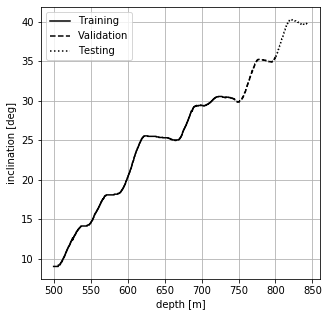

In [10]:
rcParams['figure.figsize'] = 5, 5

plt.plot(df1['Measured Depth m'].ffill(),df1['MWD Continuous Inclination dega'].ffill(),c="black", linestyle="-", label="Training")
plt.plot(df2['Measured Depth m'].ffill(),df2['MWD Continuous Inclination dega'].ffill(),c="black", linestyle="--", label="Validation")
plt.plot(df3['Measured Depth m'].ffill(),df3['MWD Continuous Inclination dega'].ffill(),c="black", linestyle=":", label="Testing")
plt.grid(True)
plt.legend()
plt.xlabel("depth [m]")
plt.ylabel("inclination [deg]")
plt.savefig("well.pdf", dpi=300,bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

Chart for visualizing parts of the dataset with the same split as above.

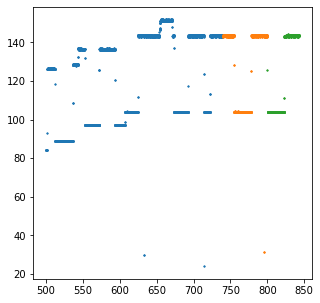

In [11]:
plt.scatter(df1['Measured Depth m'].ffill(),df1['Average Rotary Speed rpm'].ffill(), s=1)
plt.scatter(df2['Measured Depth m'].ffill(),df2['Average Rotary Speed rpm'].ffill(), s=1)
plt.scatter(df3['Measured Depth m'].ffill(),df3['Average Rotary Speed rpm'].ffill(), s=1)

Function to evaluate the results. It has the same preparation routine as seen before. It generates a number of charts.

In [12]:
def testmodel(matrix):
    
    [model, start, stop,memory, predictions, scaler1, scaler2, scaler3, scaler4] = matrix


    df = pd.read_csv('F9ADepth.csv')

    start = start
    stop = stop
    step = 0.230876

    X = np.arange(start,stop,step)
    X = X.reshape(X.shape[0],1)



    %matplotlib inline
    rcParams['figure.figsize'] = 5, 5

    X = np.arange(start,stop,step)
    X = X.reshape(X.shape[0],1)

    my_data1 = sampling_fix(df, 'MWD Continuous Inclination dega',start,stop,1.7,1,0).predict(X)
    my_data2 = sampling_fix(df, 'Average Surface Torque kN.m',start,stop,1.7,3,0).predict(X)
    my_data3 = sampling_fix(df, 'Average Rotary Speed rpm',start,stop,1.7,3,0).predict(X)
    my_data4 = sampling_fix(df, 'Rate of Penetration m/h',start,stop,0.5,1,0).predict(X)

    data_array = np.asarray([my_data1, my_data2, my_data3, my_data4])


    my_data1 = my_data1[:,np.newaxis]
    my_data2 = my_data2[:,np.newaxis]
    my_data3 = my_data3[:,np.newaxis]
    my_data4 = my_data4[:,np.newaxis]


    temp_data1 = pd.DataFrame(my_data1.flatten())

    range1 = temp_data1[0].diff(memory+predictions)
    
    
    range2 = np.amax(range1)

    




    my_data1 = scaler1.transform(my_data1)
    my_data2 = scaler2.transform(my_data2)
    my_data3 = scaler3.transform(my_data3)
    my_data4 = scaler4.transform(my_data4)


    X1 = prepareinput(my_data1, memory)


    X2 = prepareinput_nozero(my_data2,memory, predictions)
    X3 = prepareinput_nozero(my_data3,memory, predictions)
    X4 = prepareinput_nozero(my_data4,memory, predictions)


    y_temp = prepareoutput(my_data1, memory, predictions)

    stack = []
    for i in range(memory):
        stack.append(np.roll(my_data1, -i))

    X_temp = np.hstack(stack)



    X_min_for_y = X_temp[:,0]

    y = y_temp - X_min_for_y[:,np.newaxis]


    
    data_length = len(my_data1)-memory-predictions


    border2 = data_length

    X1_test = X1[:border2]
    X2_test = X2[:border2]
    X3_test = X3[:border2]
    X4_test = X4[:border2]


    y_test = y[:border2]

    X1_test = X1_test.reshape((X1_test.shape[0],X1_test.shape[1],1))
    X2_test = X2_test.reshape((X2_test.shape[0],X2_test.shape[1],1))
    X3_test = X3_test.reshape((X3_test.shape[0],X3_test.shape[1],1))
    X4_test = X4_test.reshape((X4_test.shape[0],X4_test.shape[1],1))
    X_test_con  = np.concatenate((X2_test,  X3_test,  X4_test),  axis=2)
    X_test = [X1_test, X_test_con]

    Xtest = model.predict(X_test)
    
    plotsteps = np.arange(0, int(border2),20)
    for j in plotsteps:
        shape = (7,1)
        fig = plt.figure()
        fig.tight_layout()
        fig.subplots_adjust(hspace = 1)
        ax1 = plt.subplot2grid(shape, (0,0), rowspan=4)    
        ax2 = plt.subplot2grid(shape, (4,0), sharex=ax1)
        ax3 = plt.subplot2grid(shape, (5,0), sharex=ax1)    
        ax4 = plt.subplot2grid(shape, (6,0), sharex=ax1)

        #for ax in fig.axes:
        #    plt.setp(ax.get_xticklabels(), visible=False)

        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.setp(ax2.get_xticklabels(), visible=False)
        plt.setp(ax3.get_xticklabels(), visible=False)
        
        
        known_attributes = ['Average Surface Torque', 'Average Rotary Speed', 'Rate of Penetration']

        col = ["","#000000", "#000000","#000000"]
        i=0
        
        x1=np.arange(-19.855336,0,0.230876)
        x2=np.arange(0,23.0876,0.230876)
        x3=np.arange(-19.855336,23.0875,0.230876)
        for axe in fig.axes:
            if i == 0:
                tr = j
                axe.plot(x2,y_test[tr],linewidth=2,alpha=1,c='black', linestyle=":",label='inclination ground truth')
                axe.plot(x1,X1_test[tr], linewidth=2,alpha=1, c='black', linestyle="--" , label="inclination input")
                axe.plot(x2,Xtest[tr],c='black',linestyle="-", label='inclination prediction')
                #axe.set_title('Testing results')
                #axe.set_facecolor('xkcd:light grey')
                axe.legend()
                axe.grid(True)

            else:

                axe.plot(x3,X_test[1][tr,:,i-1],label=known_attributes[i-1], c=col[i]) 
                #axe.set_facecolor('xkcd:ivory')
                axe.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
               ncol=2, mode="expand", borderaxespad=0.)
                axe.axes.set_yticks([0.25,0.75], minor=False)
                axe.axes.set_ylim([0,1])
                axe.grid(True)
            i = i + 1
        plt.xlabel("Distance from data gap [m]")
        plt.savefig(str(j) + ".pdf", dpi=300,bbox_inches = 'tight',
    pad_inches = 0)
        plt.show()
    
    
    print (np.log(model.evaluate(X_test, y_test)))
    
    return 

Calling the function to generate a set of charts, formatted to be used in paper.

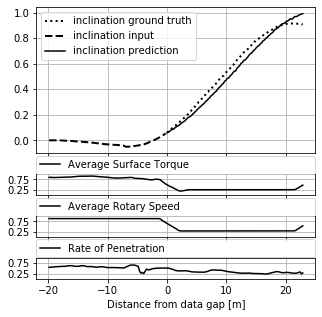

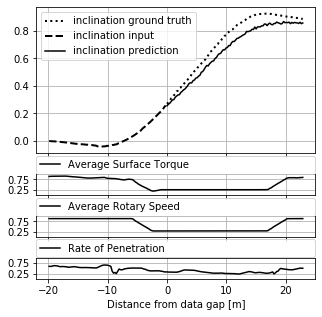

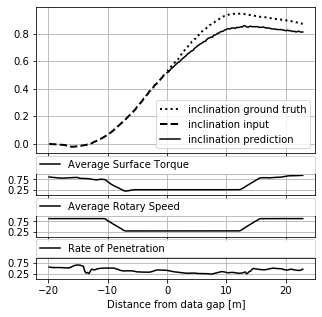

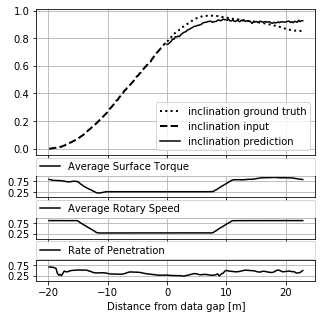

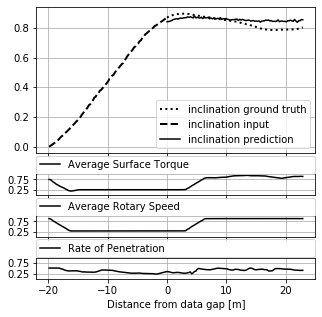

87/87 [==============================] - 0s 218us/step
-5.626368439384213


In [13]:


testmodel([model, middle-20, end, 86, 100, scaler1, scaler2, scaler3, scaler4])


Generate a number of various plots. This was used in the exploratory stage to figure out the best way of visualizing the results.

In [14]:
def hairyplot(matrix):
        
    [model, start,mid, stop,memory, predictions, scaler1, scaler2, scaler3, scaler4] = matrix


    df = pd.read_csv('F9ADepth.csv')

    start = start
    stop = stop
    step = 0.230876

    X = np.arange(start,stop,step)
    X = X.reshape(X.shape[0],1)

    %matplotlib inline
    rcParams['figure.figsize'] = 10, 5

    X = np.arange(start,stop,step)
    X = X.reshape(X.shape[0],1)

    my_data1 = sampling_fix(df, 'MWD Continuous Inclination dega',start,stop,1.7,1,0).predict(X)
    my_data2 = sampling_fix(df, 'Average Surface Torque kN.m',start,stop,1.7,3,0).predict(X)
    my_data3 = sampling_fix(df, 'Average Rotary Speed rpm',start,stop,1.7,3,0).predict(X)
    my_data4 = sampling_fix(df, 'Rate of Penetration m/h',start,stop,0.5,1,0).predict(X)

    data_array = np.asarray([my_data1, my_data2, my_data3, my_data4])


    my_data1 = my_data1[:,np.newaxis]
    my_data2 = my_data2[:,np.newaxis]
    my_data3 = my_data3[:,np.newaxis]
    my_data4 = my_data4[:,np.newaxis]


    temp_data1 = pd.DataFrame(my_data1.flatten())

    range1 = temp_data1[0].diff(memory+predictions)
    
    
    range2 = np.amax(range1)


    my_data1 = scaler1.transform(my_data1)
    my_data2 = scaler2.transform(my_data2)
    my_data3 = scaler3.transform(my_data3)
    my_data4 = scaler4.transform(my_data4)


    X1 = prepareinput(my_data1, memory)
    X2 = prepareinput_nozero(my_data2,memory, predictions)
    X3 = prepareinput_nozero(my_data3,memory, predictions)
    X4 = prepareinput_nozero(my_data4,memory, predictions)


    y_temp = prepareoutput(my_data1, memory, predictions)

    stack = []
    for i in range(memory):
        stack.append(np.roll(my_data1, -i))

    X_temp = np.hstack(stack)



    X_min_for_y = X_temp[:,0]

    y = y_temp - X_min_for_y[:,np.newaxis]

  
    data_length = len(my_data1)-memory-predictions


    border2 = data_length

    X1_test = X1[:border2]
    X2_test = X2[:border2]
    X3_test = X3[:border2]
    X4_test = X4[:border2]


    y_test = y[:border2]

    X1_test = X1_test.reshape((X1_test.shape[0],X1_test.shape[1],1))
    X2_test = X2_test.reshape((X2_test.shape[0],X2_test.shape[1],1))
    X3_test = X3_test.reshape((X3_test.shape[0],X3_test.shape[1],1))
    X4_test = X4_test.reshape((X4_test.shape[0],X4_test.shape[1],1))
    X_test_con  = np.concatenate((X2_test,  X3_test,  X4_test),  axis=2)
    X_test = [X1_test, X_test_con]

    Xtest = model.predict(X_test)
    
    
    d1 = int(((mid-start)/step)*0.8)
    d2 = int((mid-start)/step)
    

    inc = scaler1.inverse_transform([X1[:-1,1].cumsum()])
    inc = inc[0]
    inc1 = inc[:d1]
    inc2 = inc[d1:d2]
    inc3 = inc[d2:]
    print(len(inc3))
    
    rcParams['figure.figsize'] = 20, 15


    
    ##############################################################
    
    df2 = pd.DataFrame()
    df2['Inc'] = sampling_fix(df, 'MWD Continuous Inclination dega',start,stop,1.7,1,0).predict(X)
    df2['Inc'] = df2['Inc'].diff(100)

    df2 = df2.dropna(how='any')

    inc5 = np.percentile(np.asarray(df2['Inc']),5)
    inc50 = np.percentile(np.asarray(df2['Inc']),50)
    inc95 = np.percentile(np.asarray(df2['Inc']),95)
    print("5th percentile in inclination, 23m ahead: " + str(inc5))
    print("50th percentile in inclination, 23m ahead: " + str(inc50))
    print("95th percentile in inclination, 23m ahead: " + str(inc95))
    
    ##############################################################

    
    for i in range(len(X1_test)):
        hair = Xtest[i]/scaler1.scale_

        x_hair = np.arange(memory+i,memory+i+predictions,1)
        y_hair = hair+inc[i]
        plt.plot(x_hair,y_hair,linewidth=1, color='black',alpha=0.05)
    plt.title("Prediction overlay without reference, full prediction")  
    
    plt.show()
    
    for i in range(len(X1_test)):
        hair = Xtest[i][:50]/scaler1.scale_

        x_hair = np.arange(memory+i,memory+i+predictions//2,1)
        y_hair = hair+inc[i]
        plt.plot(x_hair,y_hair,linewidth=1, color='black',alpha=0.05)
    plt.title("Prediction overlay without reference, first half prediction")    
    plt.show()
    
    plt.plot(np.arange(100,d2+len(inc3)+100,1),inc+inc5,linewidth=1,c='gray', label="5th and 95th percentile, Bayesian")
    plt.plot(np.arange(100,d2+len(inc3)+100,1),inc+inc95,linewidth=1,c='gray')
    
    plt.plot(np.arange(0,d1,1),inc1,linewidth=1,c='r', label="train")
    plt.plot(np.arange(d1,d2,1),inc2,linewidth=1,c='b',label="validate")
    plt.plot(np.arange(d2,d2+len(inc3),1),inc3,linewidth=1,c='g', label="test")
    
    for i in range(len(X1_test)):
        hair =Xtest[i]/scaler1.scale_

        x_hair = np.arange(memory+i,memory+i+predictions,1)
        y_hair = hair+inc[i]
        plt.plot(x_hair,y_hair,linewidth=1, color='black',alpha=0.05)
    
    for i in range(1,10):
        plt.plot(np.arange(0,d1,1),inc1,linewidth=4*i,alpha=0.01,c='r')
        plt.plot(np.arange(d1,d2,1),inc2,linewidth=4*i,alpha=0.01,c='b')
        plt.plot(np.arange(d2,d2+len(inc3),1),inc3,linewidth=4*i,alpha=0.01,c='g')
    plt.title("Prediction overlay")
    plt.legend()
    plt.savefig("Hairy Inclination.png", dpi=600)
    plt.show()
    
    

    Xtest = model.predict(X_test)
    
    rcParams['figure.figsize'] = 11, 5

    error = []
    for j in range(len(X_test[0])):
        tr = j #np.random.randint(0, border2 - border1)
        error.append((y_test[tr]-Xtest[tr])/scaler1.scale_)
    plt.plot(np.rot90(error,3), alpha=0.01, c="black")
    plt.title("Global error, over whole dataset")
    plt.show()
    
    plt.plot(np.rot90(error[:1039-86],3), alpha=0.01, c="black")
    plt.title("Global error, over Training dataset")
    plt.show()
    
    plt.plot(np.rot90(error[1039-86:1299-86],3), alpha=0.03, c="black")
    plt.title("Global error, over Validation dataset")
    plt.show()
    
    
    plt.plot(np.rot90(error[1299-86:],3), alpha=0.05, c="black")
    plt.title("Global error, over Test dataset")
    plt.show()
    
    error5 = np.percentile(error,5,axis=0).flatten()
    error50 = np.percentile(error,50,axis=0).flatten()
    error95 = np.percentile(error,95,axis=0).flatten()

    plt.title("Error in function of prediction distance")
    plt.plot(error95, linewidth=1, c="gray", label="95th percentile")
    plt.plot(error50, linewidth=2, c="black",label="50th percentile")
    plt.plot(error5, linewidth=1, c="gray",label="5th percentile")
    plt.legend()
    plt.grid()
    plt.show();
    
    
    error5 = np.percentile(error[1299-86:],5,axis=0).flatten()
    error50 = np.percentile(error[1299-86:],50,axis=0).flatten()
    error95 = np.percentile(error[1299-86:],95,axis=0).flatten()

    plt.title("Error in function of prediction distance, Test only")
    plt.plot(error95, linewidth=1, c="gray", label="95th percentile")
    plt.plot(error50, linewidth=2, c="black",label="50th percentile")
    plt.plot(error5, linewidth=1, c="gray",label="5th percentile")
    plt.legend()
    plt.grid()
    plt.show();
    

    
    
    plt.title("Average absolute error as a function of prediction distance")
    plt.plot(np.average(np.abs(error), axis=0))
    plt.grid()
    plt.show()
    
    

    
    return error

186
5th percentile in inclination, 23m ahead: -0.3716583333333361
50th percentile in inclination, 23m ahead: 2.0203956043956044
95th percentile in inclination, 23m ahead: 5.100755999515183


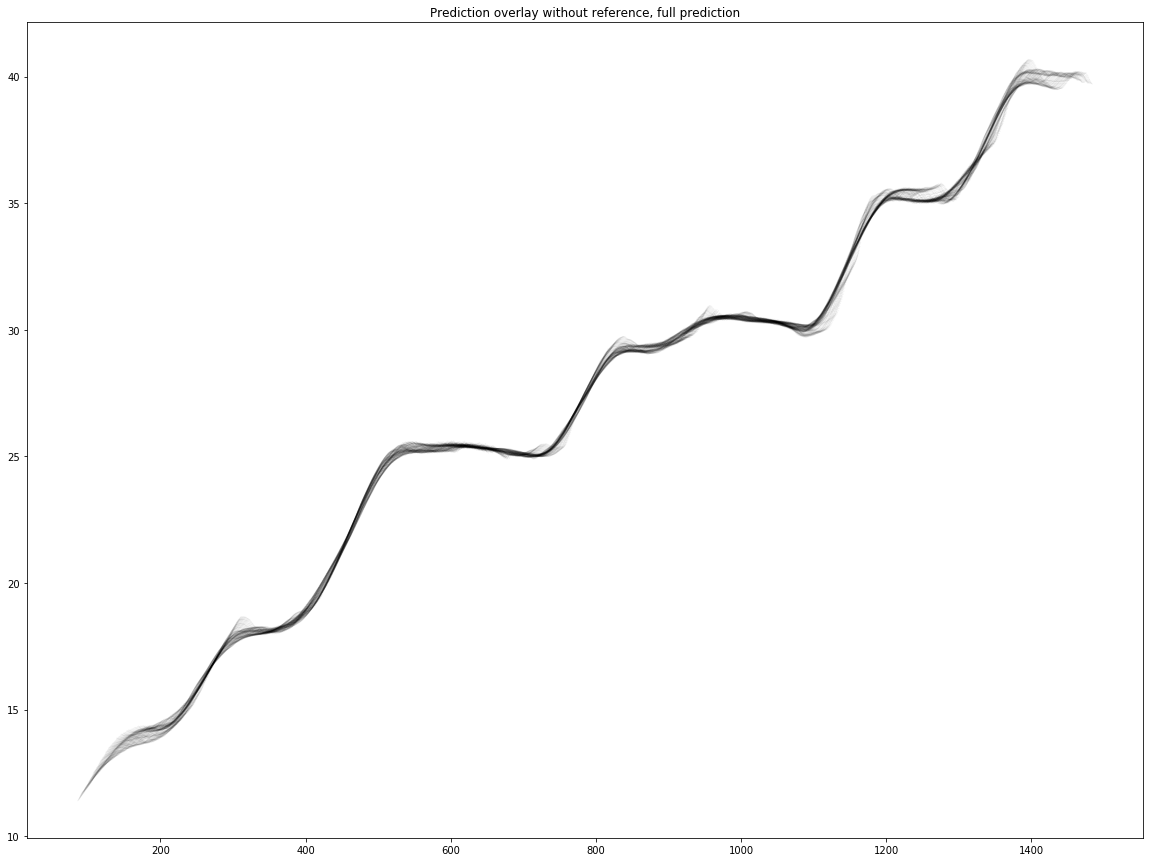

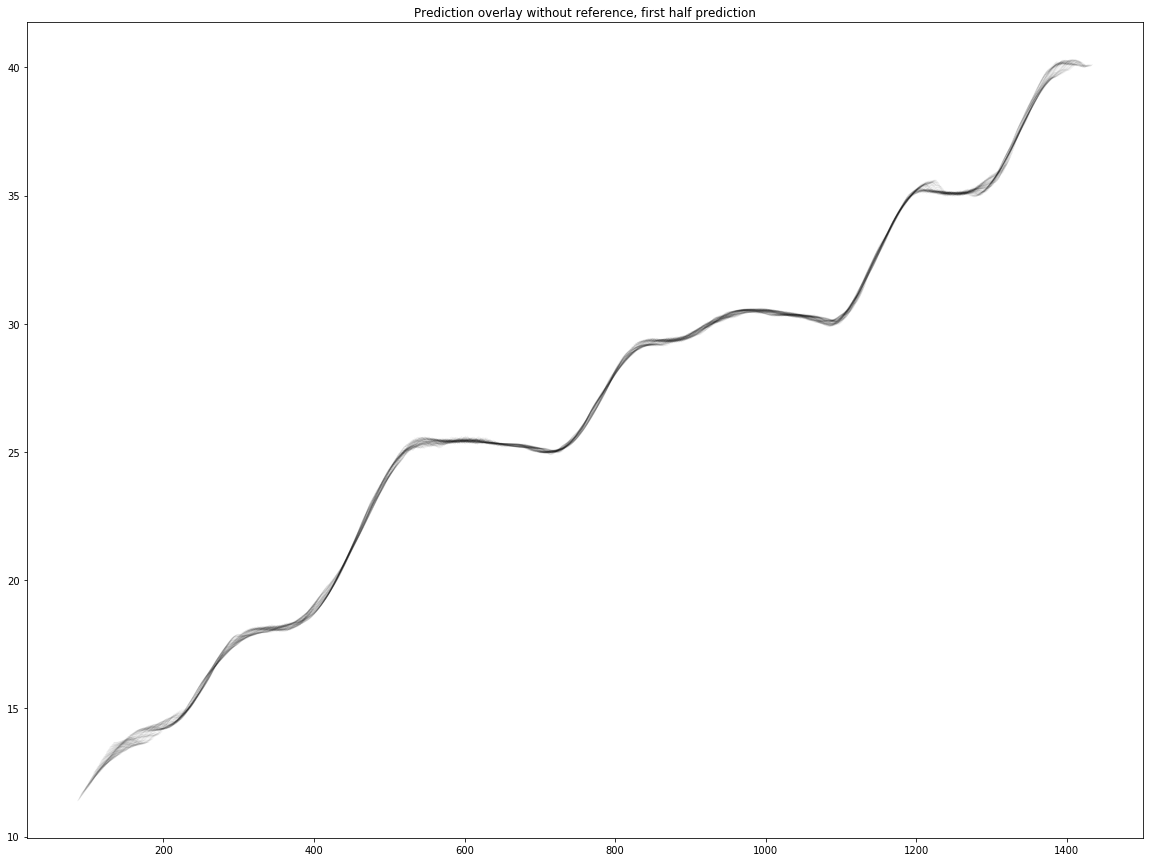

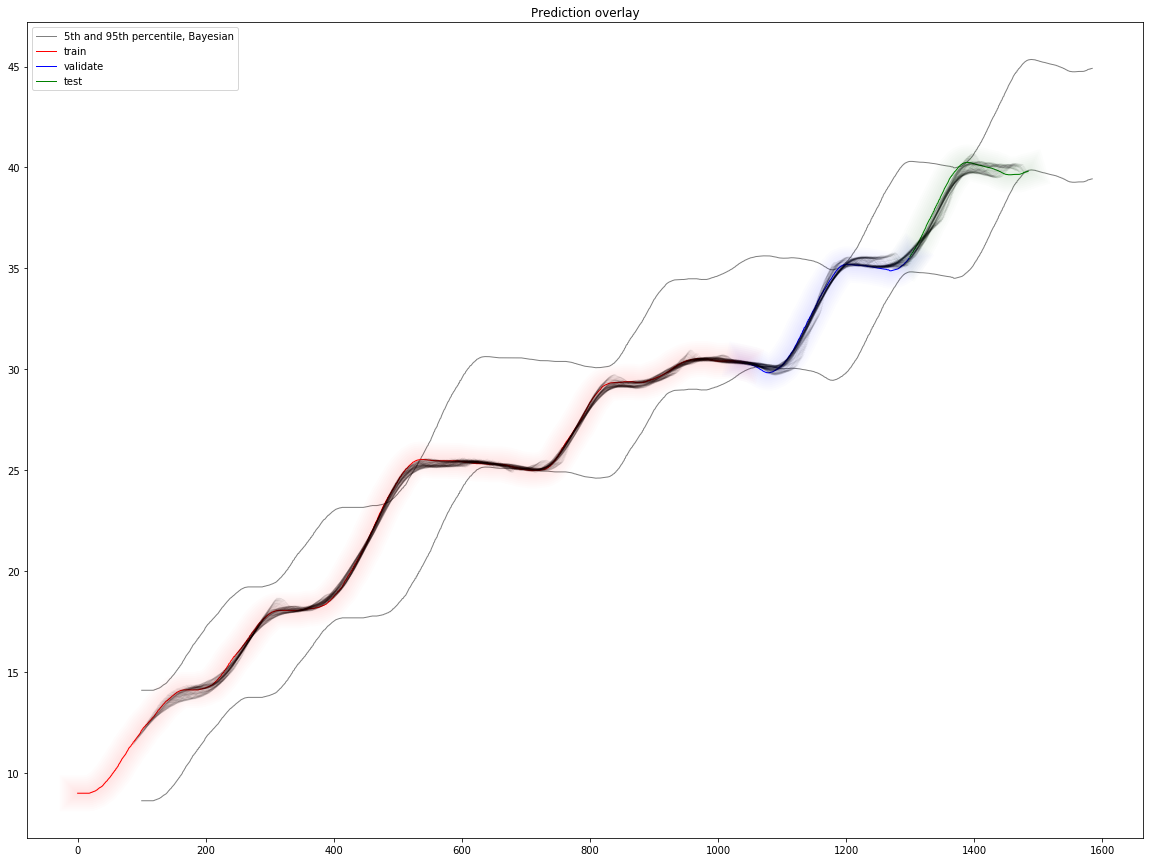

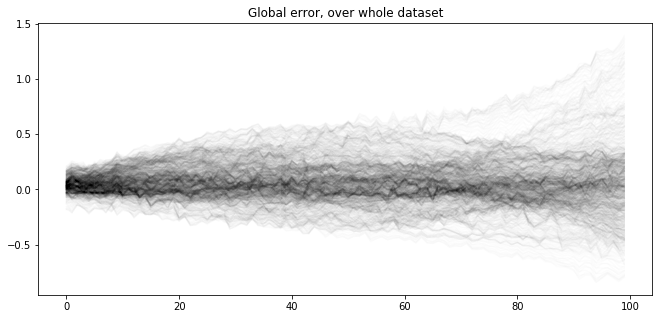

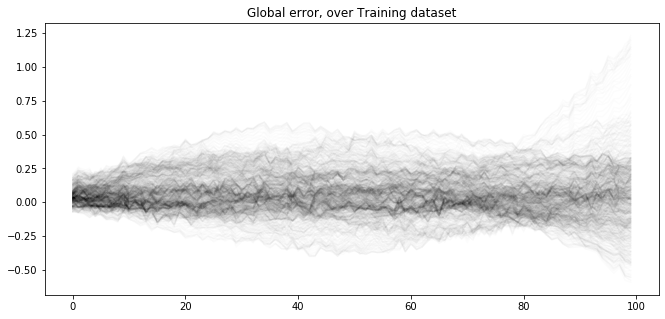

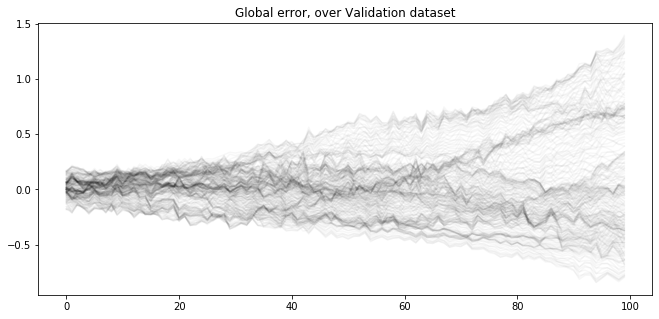

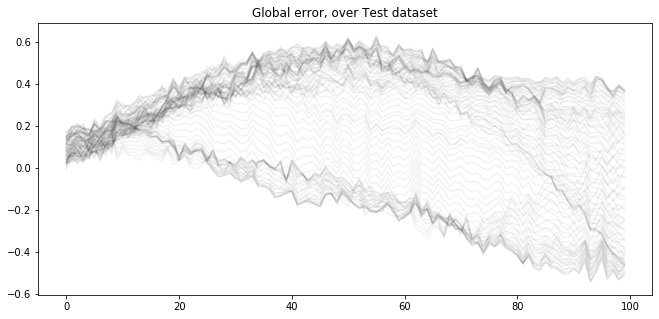

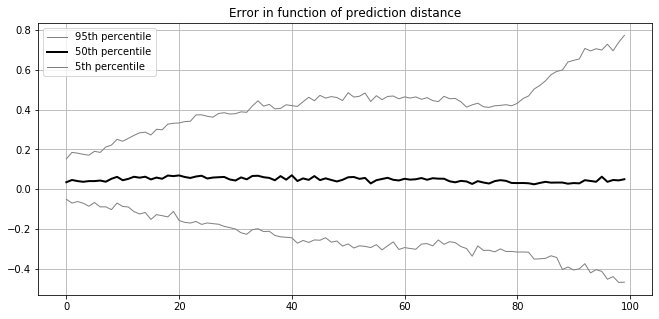

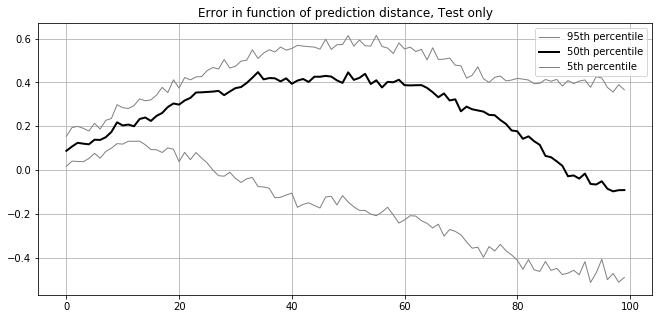

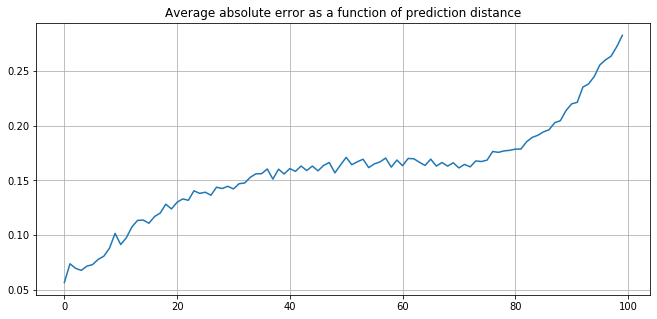

In [15]:
error = hairyplot([model, begin,middle, end, 86, 100, scaler1, scaler2, scaler3, scaler4])

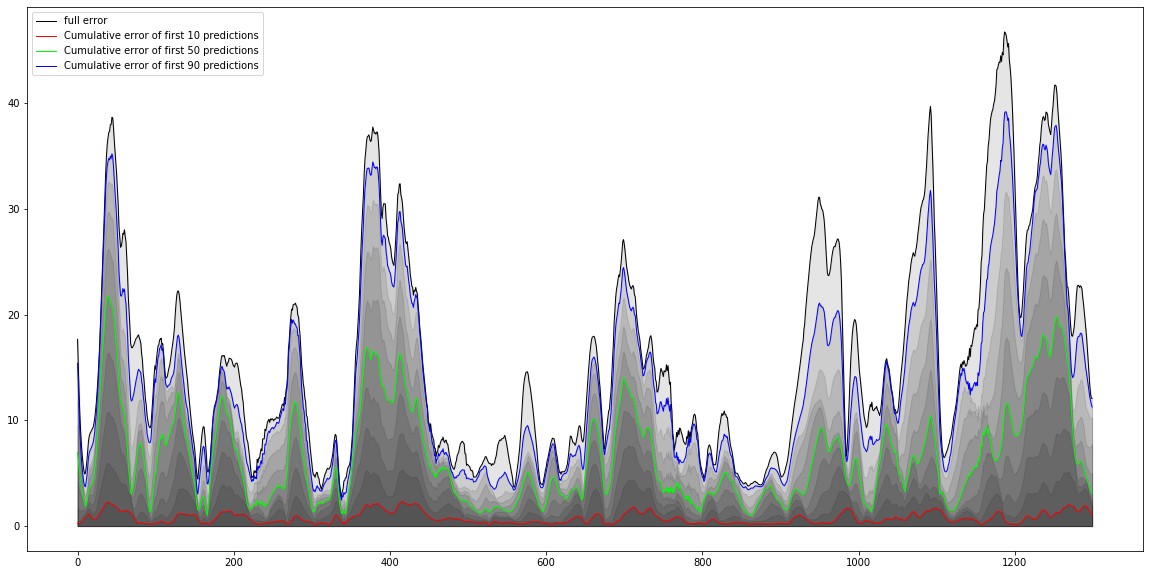

In [16]:

rcParams['figure.figsize'] = 20,10
error = np.asarray(error)

for i in np.arange(10,101,10):
    _ = plt.fill_between(np.arange(0,len(error),1), np.sum(np.abs(error[:,:i]), axis=1),color='black', alpha='0.1')
_ = plt.plot(np.arange(0,len(error),1), np.sum(np.abs(error[:,:100]), axis=1), c="black",linewidth=1, label="full error")

_ = plt.plot(np.sum(np.abs(error[:,:10]), axis=1), c="r", label="Cumulative error of first 10 predictions",linewidth=1)
_ = plt.plot(np.sum(np.abs(error[:,:50]), axis=1),c="lime", label="Cumulative error of first 50 predictions",linewidth=1)
_ = plt.plot(np.sum(np.abs(error[:,:-10]), axis=1), c="b",label="Cumulative error of first 90 predictions",linewidth=1)
plt.legend()
plt.savefig("chart.png", dpi=400)
plt.show()


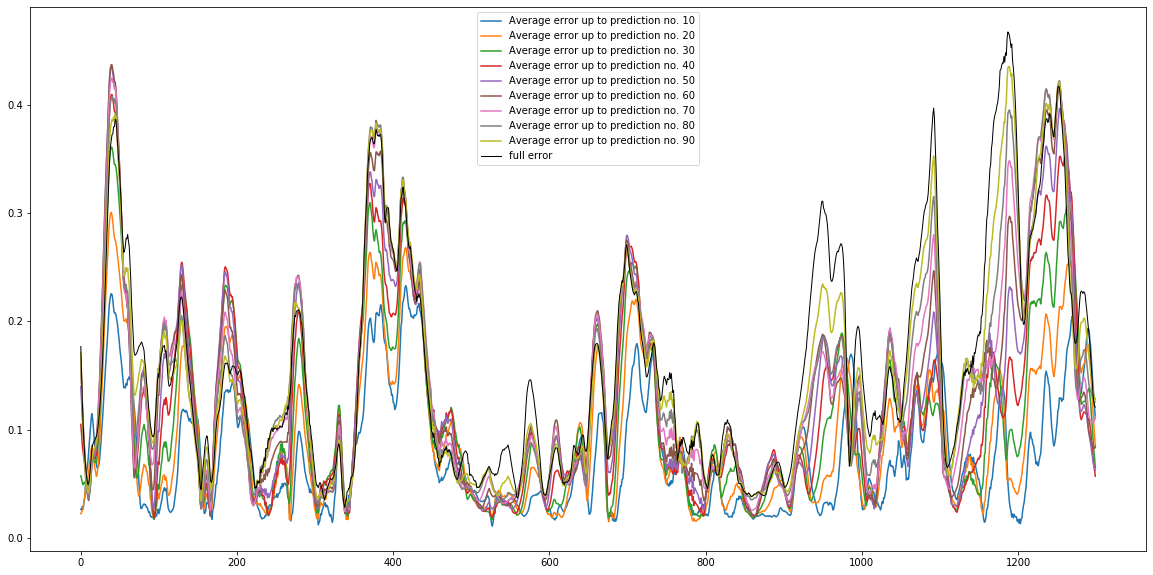

In [17]:

for i in np.arange(10,100,10):

    mylabel = "Average error up to prediction no. " + str(i)
    _ = plt.plot(np.arange(0,len(error),1), np.average(np.abs(error[:,:i]), axis=1), label=mylabel)
    #_ = plt.plot(np.arange(0,len(error),1), np.sum(np.abs(error[:,:100]), axis=1), c="black",linewidth=1, label="full error")

 
_ = plt.plot(np.arange(0,len(error),1), np.average(np.abs(error[:,:100]), axis=1), c="black",linewidth=1, label="full error")


plt.legend()

plt.show()

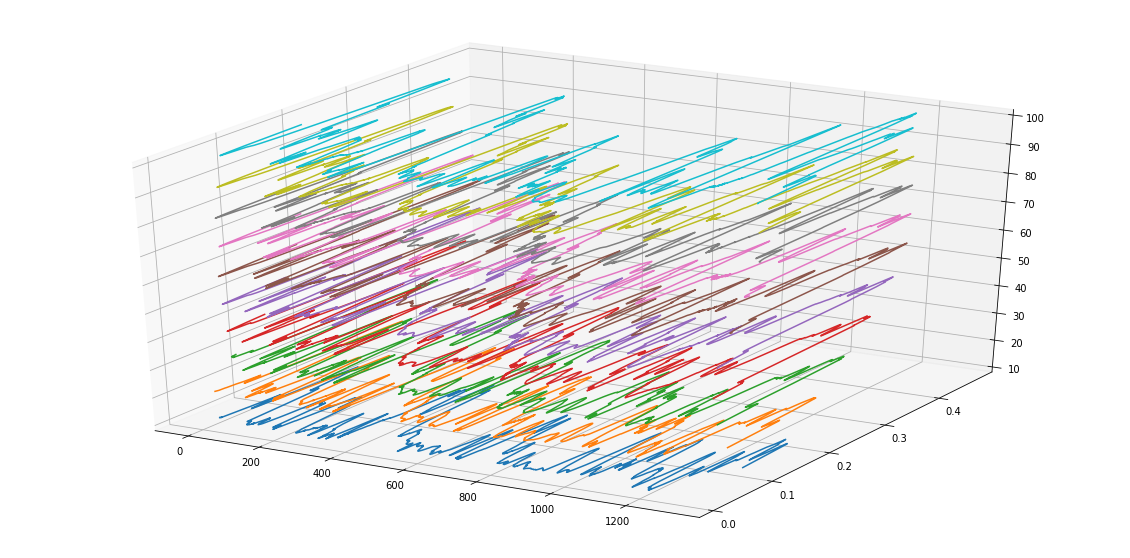

In [18]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')



for i in np.arange(10,101,10):
    _ = ax.plot(xs=np.arange(0,len(error),1), ys=np.average(np.abs(error[:,:i]), axis=1),zs=i)
    


Text(0.5, 1.0, 'Cumulative error in 10% intervals')

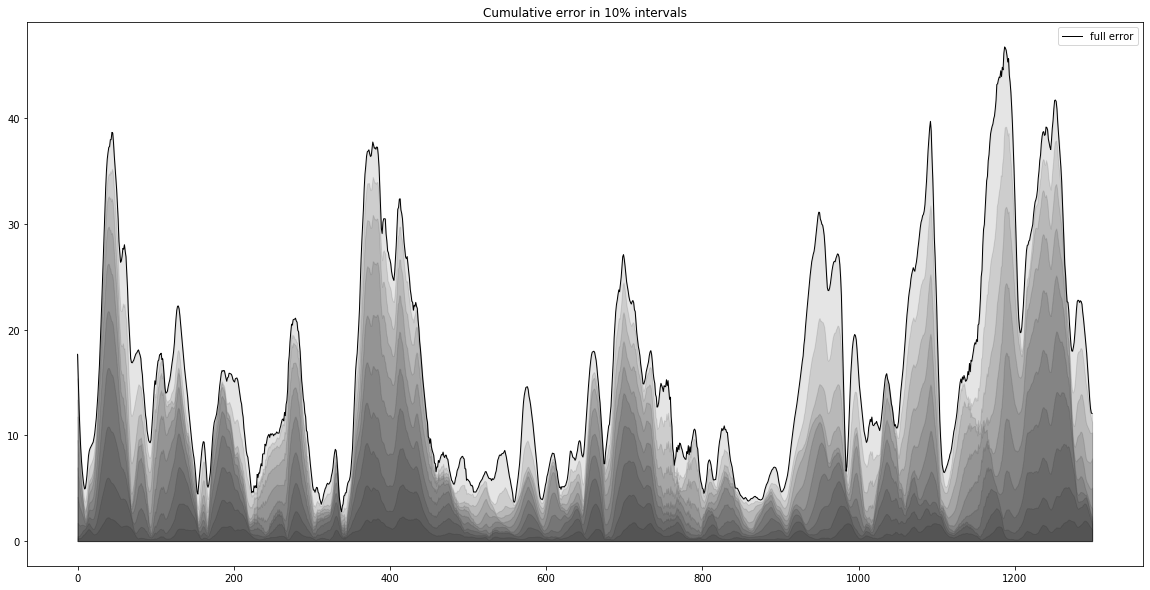

In [19]:
rcParams['figure.figsize'] = 20,10


for i in np.arange(10,101,10):
    _ = plt.fill_between(np.arange(0,len(error),1), np.sum(np.abs(error[:,:i]), axis=1),color='black', alpha='0.1')
_ = plt.plot(np.arange(0,len(error),1), np.sum(np.abs(error[:,:100]), axis=1), c="black",linewidth=1, label="full error")

plt.title("Cumulative error in 10% intervals")
plt.legend()
plt.savefig("chart.png", dpi=400)
plt.show()

(0, 1.5)

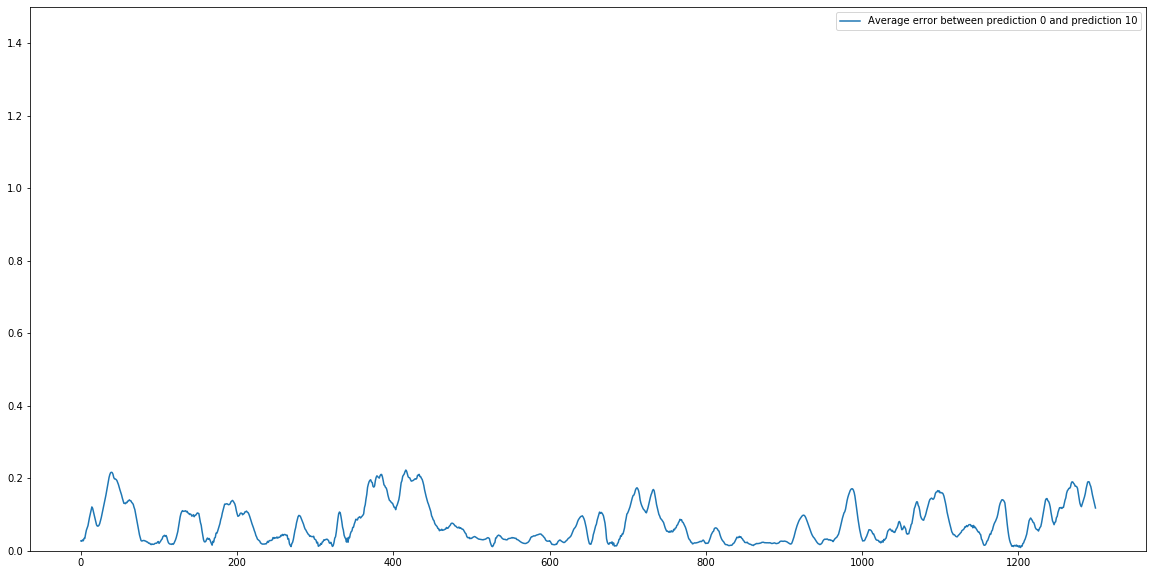

(0, 1.5)

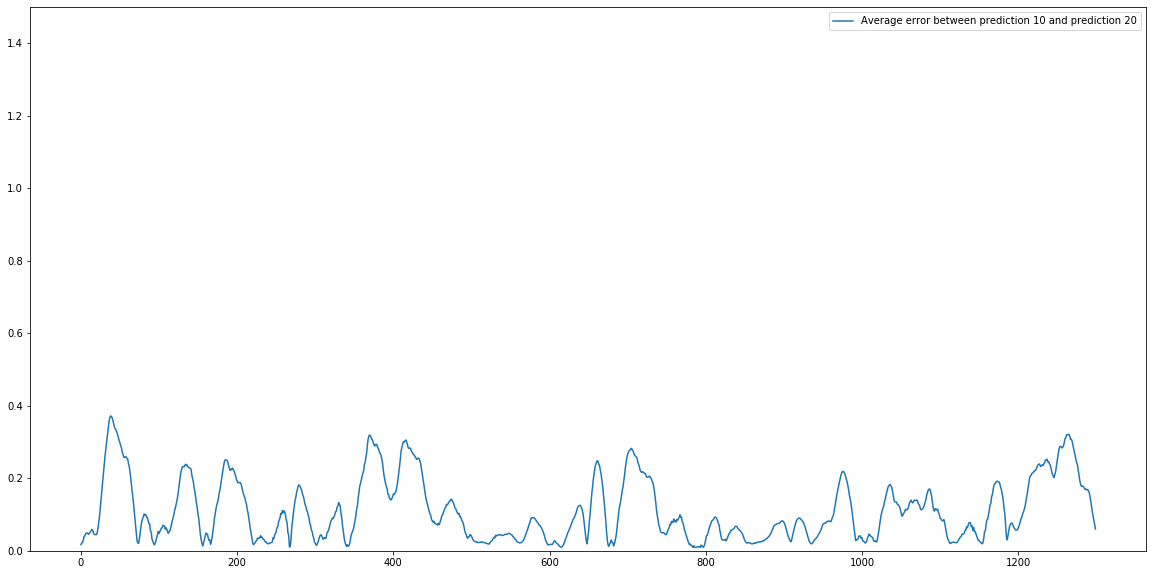

(0, 1.5)

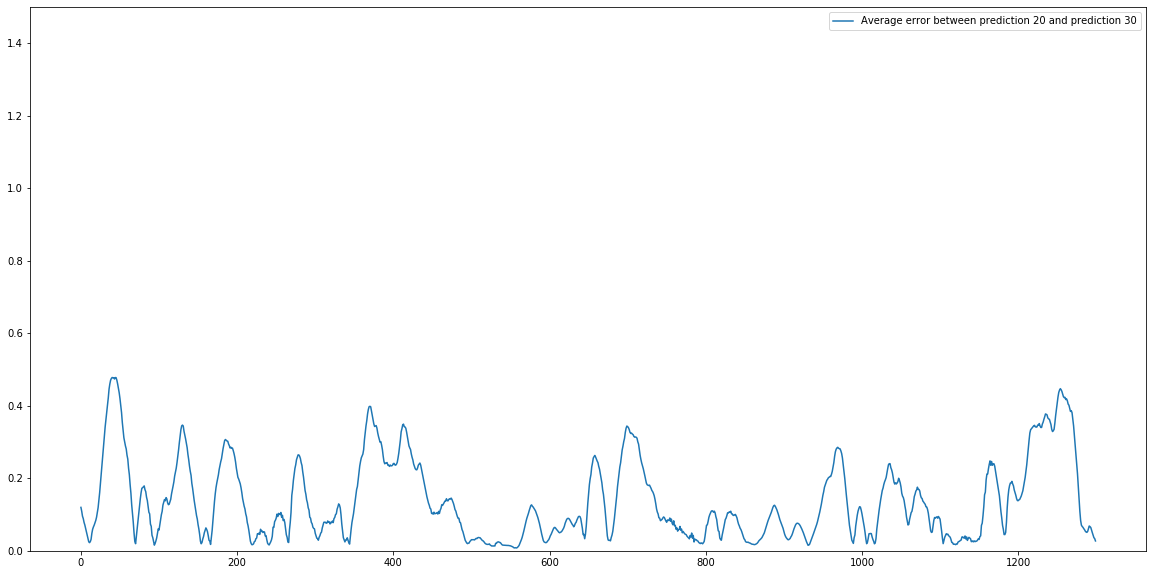

(0, 1.5)

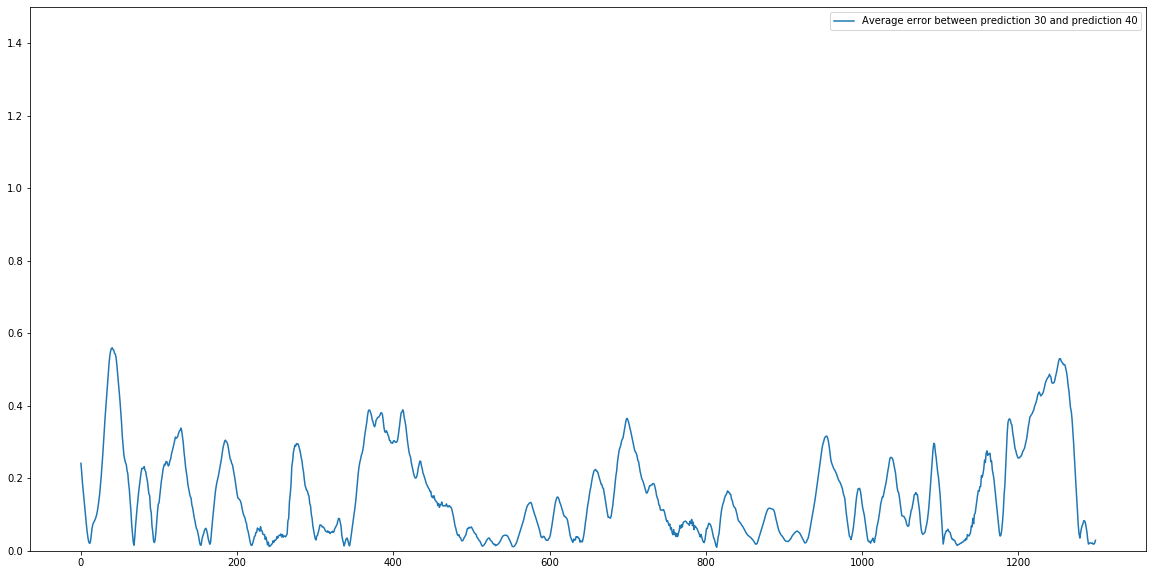

(0, 1.5)

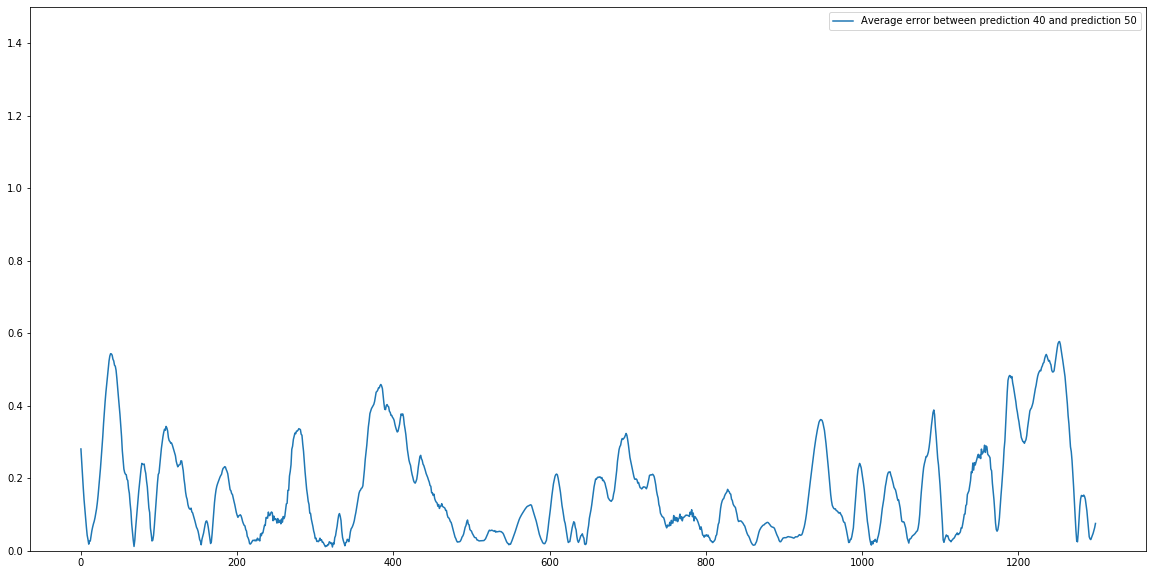

(0, 1.5)

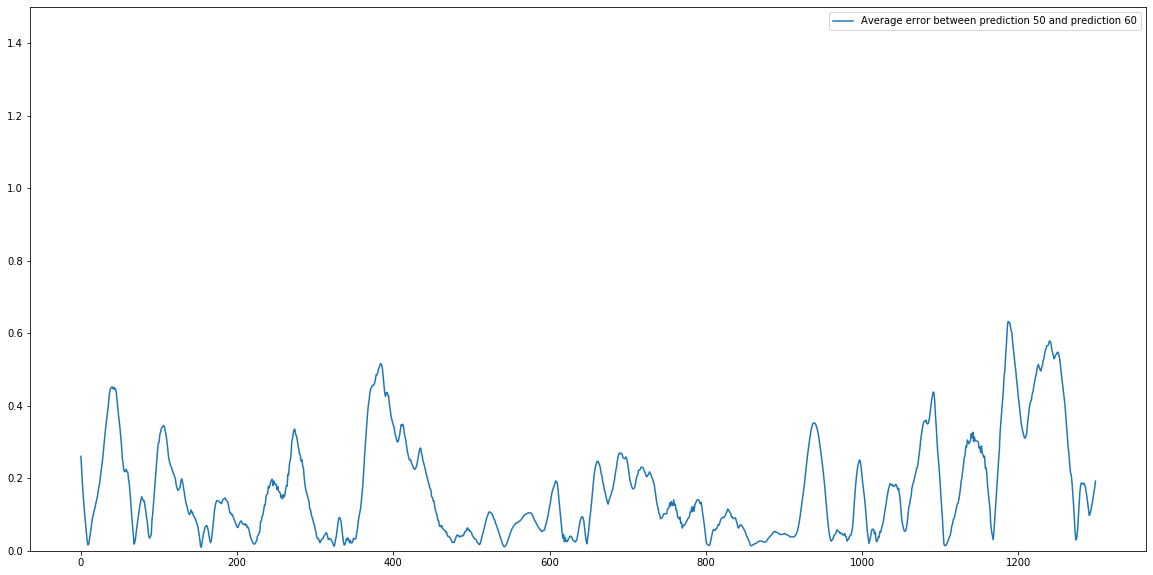

(0, 1.5)

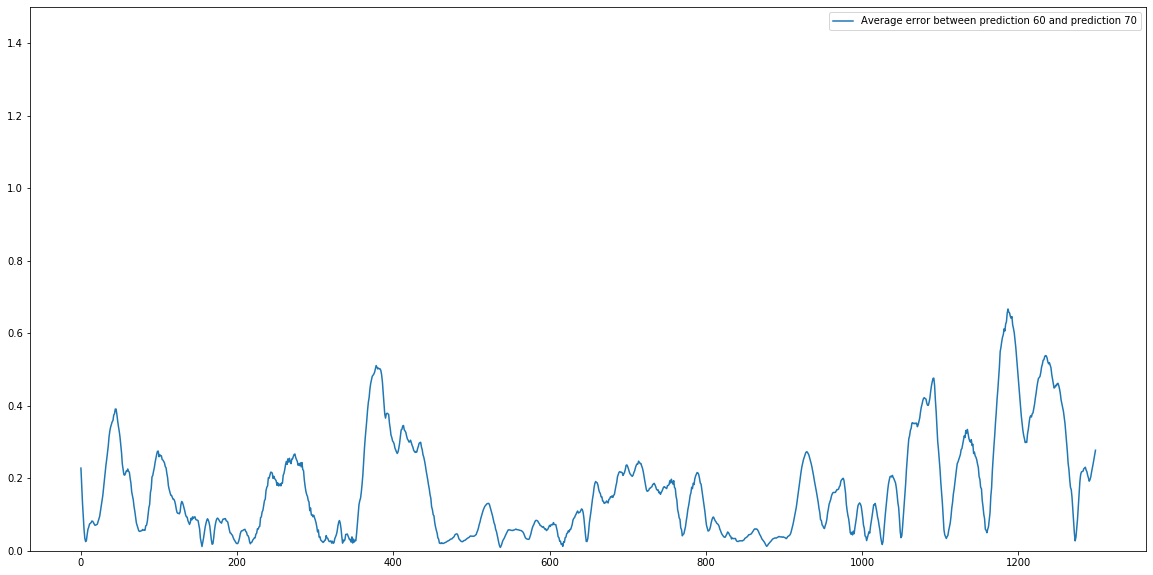

(0, 1.5)

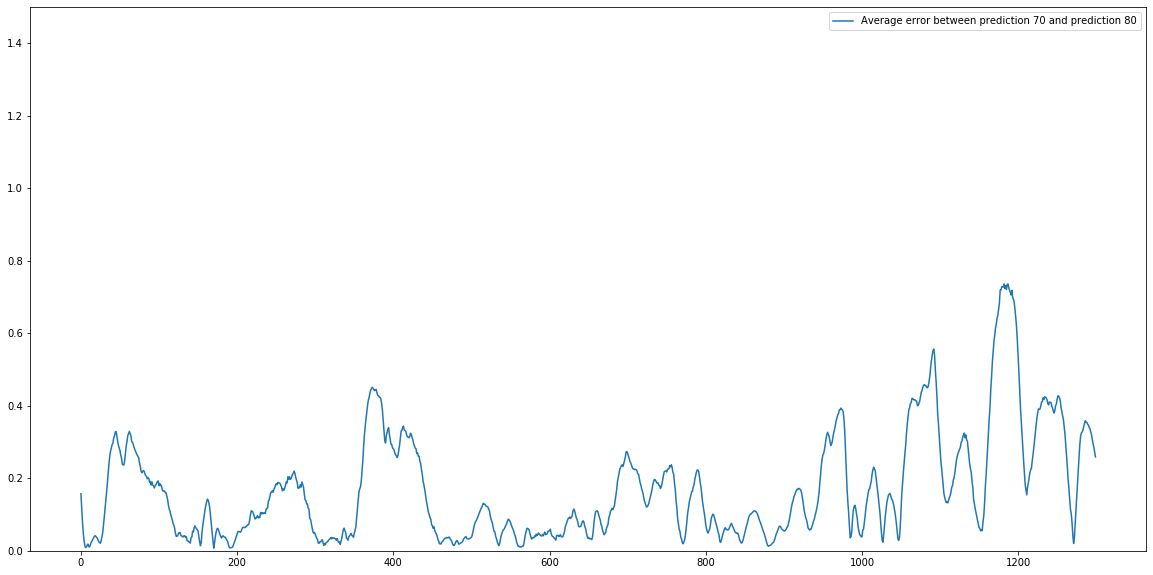

(0, 1.5)

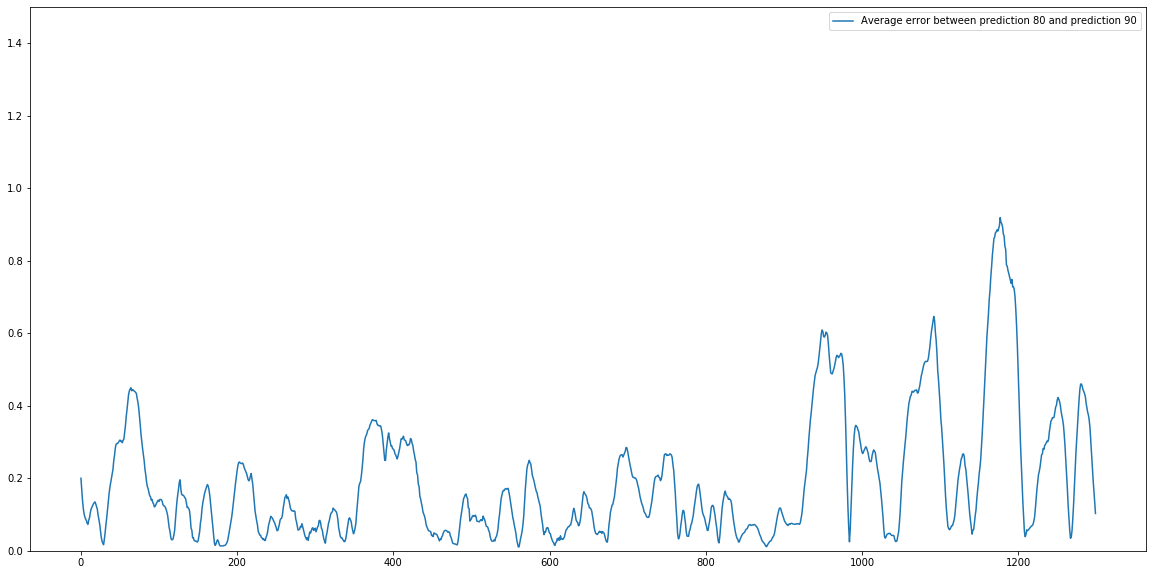

(0, 1.5)

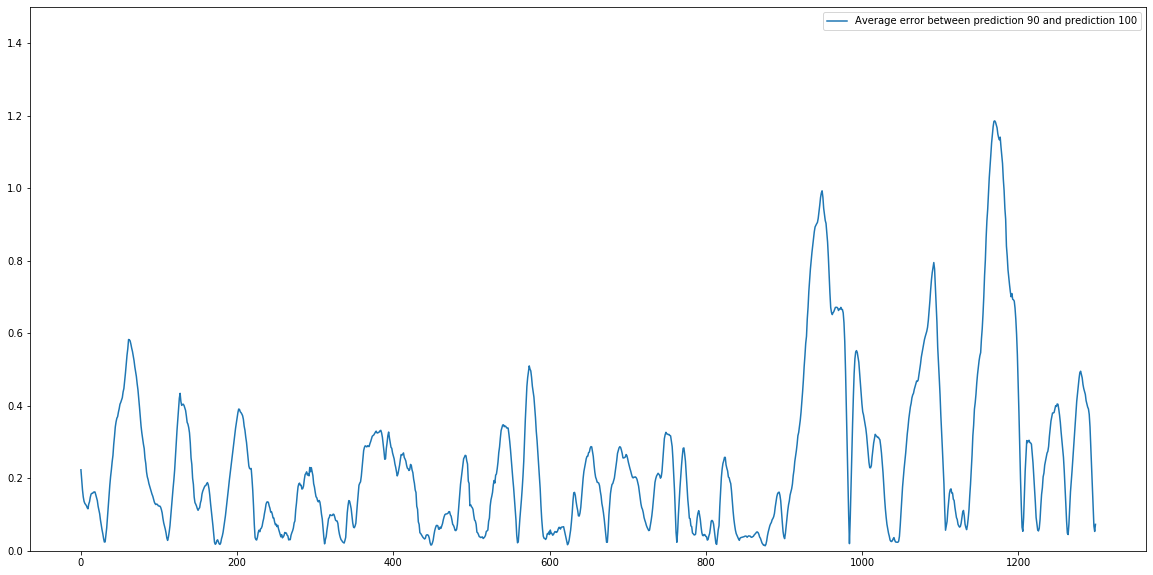

In [20]:
for i in np.arange(0,100,10):

    mylabel = "Average error between prediction " + str(i) + " and prediction " + str(i+10)
    _ = plt.plot(np.arange(0,len(error),1), np.average(np.abs(error[:,i:i+9]), axis=1), label=mylabel)
    #_ = plt.plot(np.arange(0,len(error),1), np.sum(np.abs(error[:,:100]), axis=1), c="black",linewidth=1, label="full error")
    plt.legend()
    plt.ylim(0,1.5)
    plt.savefig(str(i) + "_" + str(i+9) + ".png")
    plt.show()
 




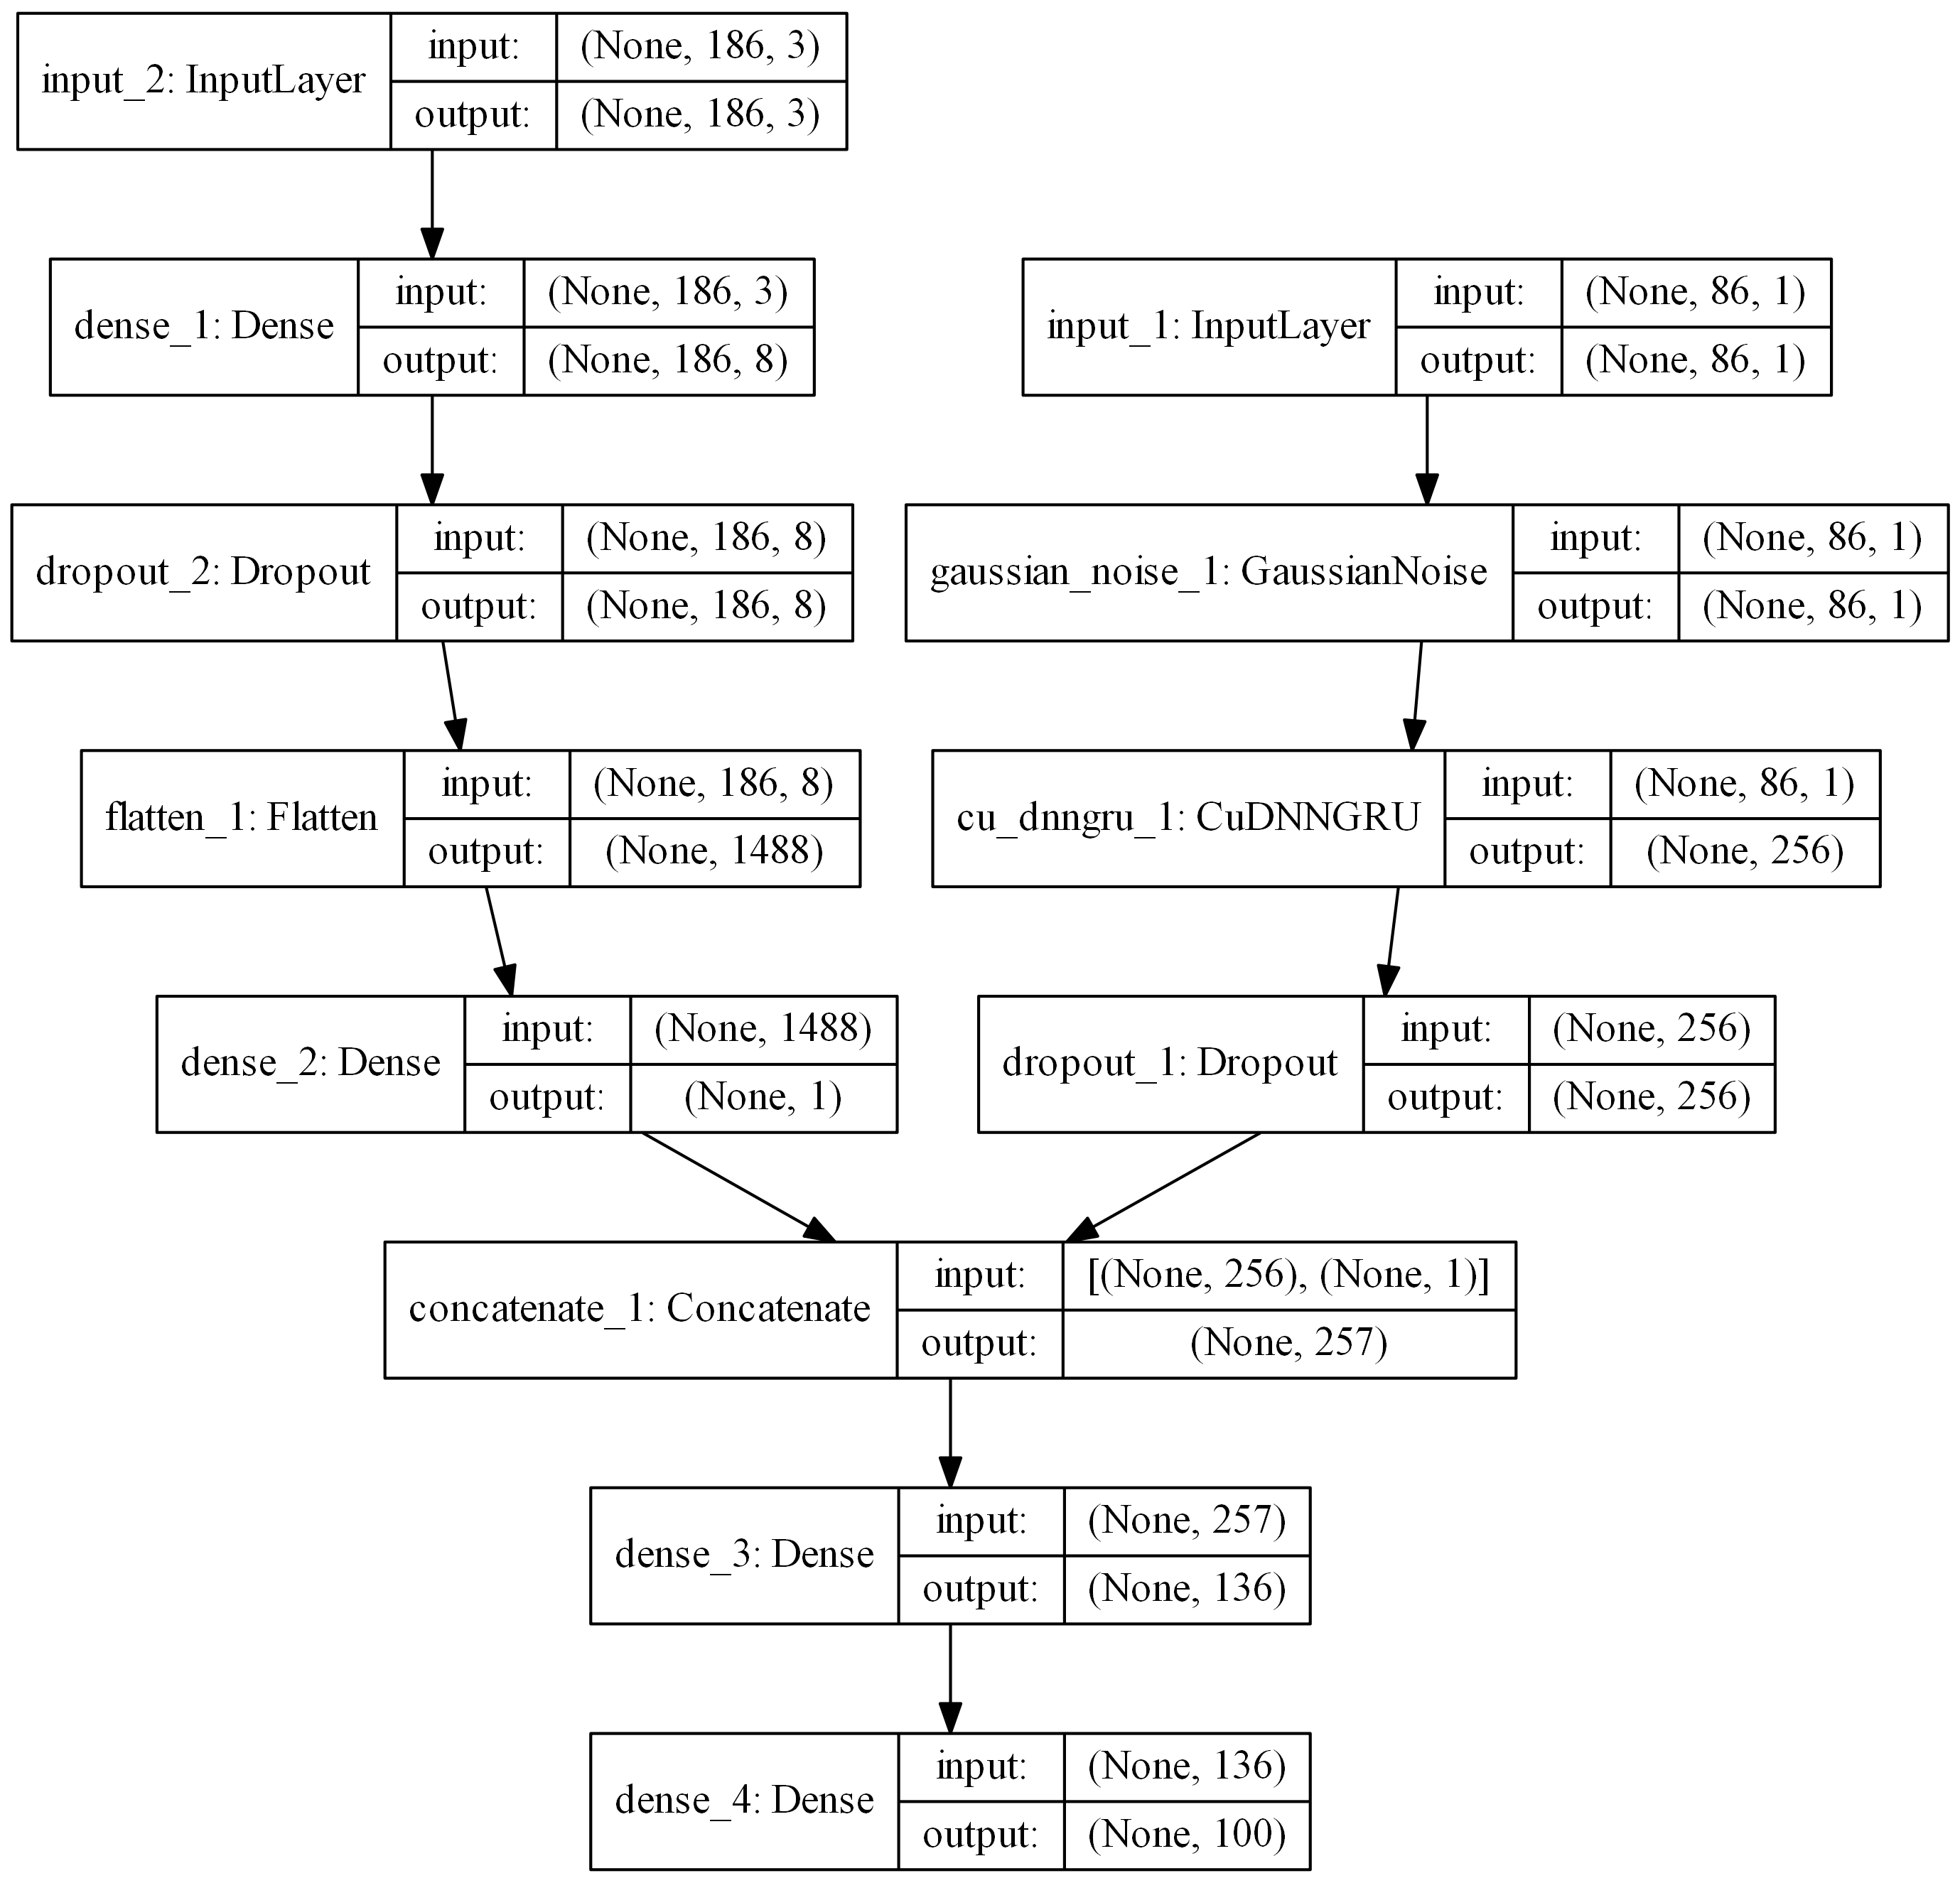

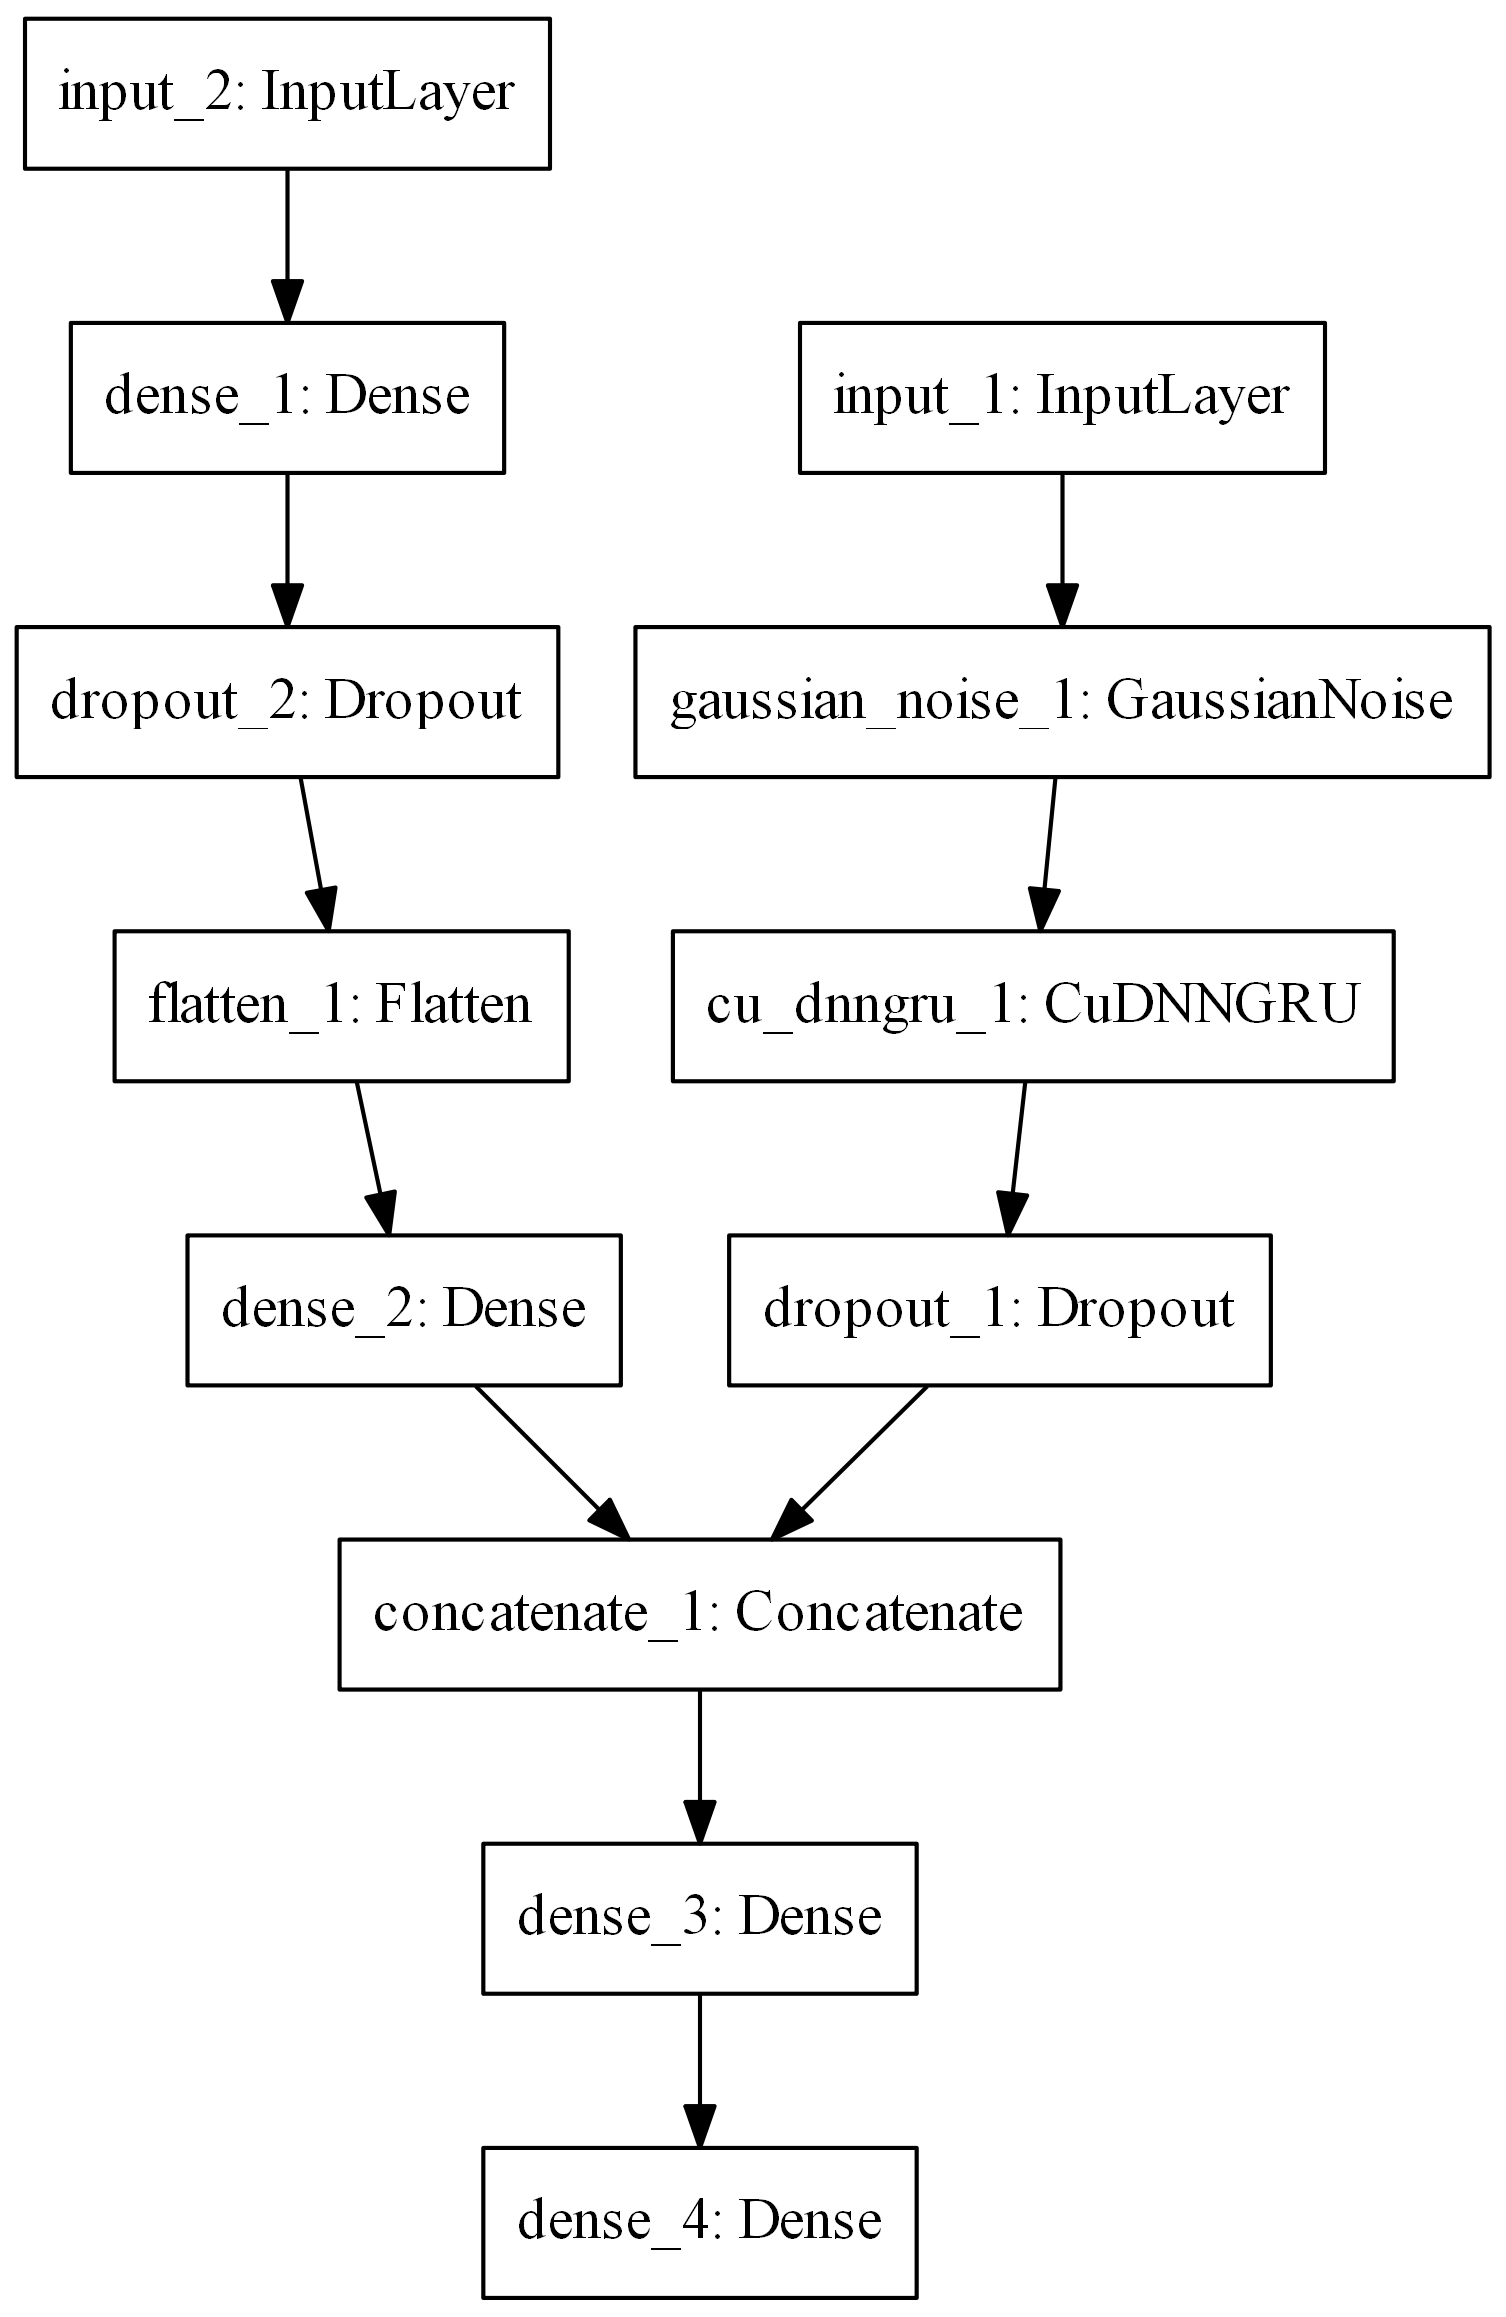

In [21]:
plot_model(model, show_shapes=True, expand_nested=False, dpi=300)
plot_model(model, show_shapes=False, expand_nested=True, dpi=300)


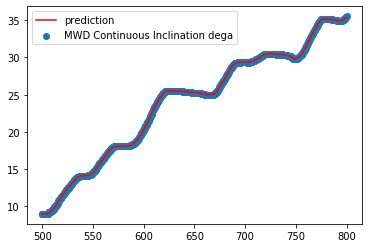

In [22]:
%matplotlib inline

X = np.arange(500,800,0.230876)
X = X.reshape(X.shape[0],1)

sampling_fix(df, 'MWD Continuous Inclination dega',500,800,1.7,1,1)

Text(0.5, 0, 'prediction distance [m]')

Text(0, 0.5, 'average absolute error [degrees]')

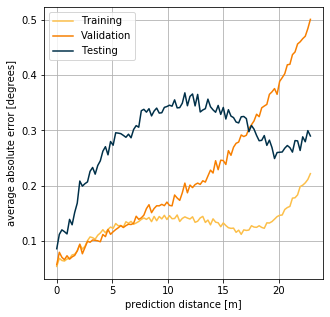

Text(0.5, 0, 'prediction distance [m]')

Text(0, 0.5, 'average absolute error [degrees]')

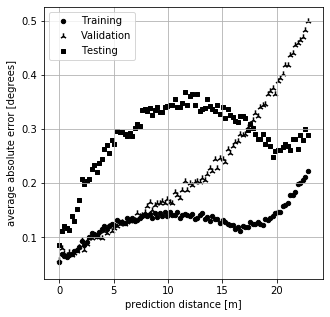

Text(0.5, 1.0, 'Average absolute error as a function of well depth')

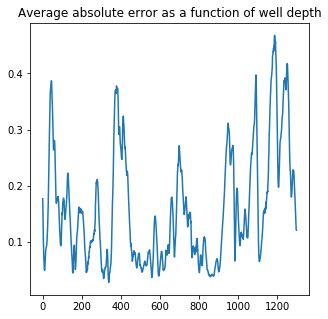

Text(0.5, 1.0, 'Average absolute error of n meters as a function of well depth')

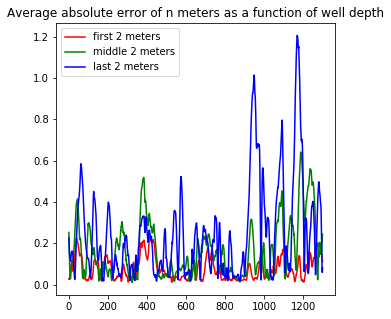

Text(0.5, 1.0, 'Global error, over Test dataset')

Text(0.5, 0, 'prediction distance [m]')

Text(0, 0.5, 'error [degrees]')

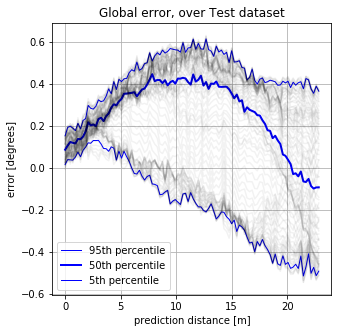

Text(0.5, 1.0, 'Average absolute error as a function of prediction distance of Test dataset')

Text(0.5, 0, 'prediction distance [steps]')

Text(0, 0.5, 'error [degrees]')

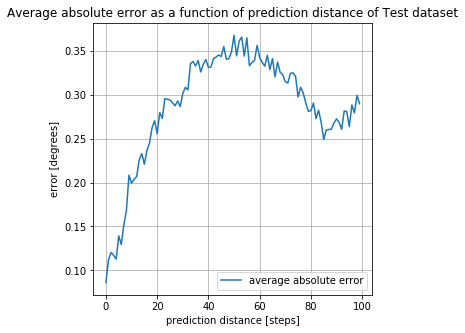

In [23]:
error5 = np.percentile(error[1299-86:],5,axis=0).flatten()
error50 = np.percentile(error[1299-86:],50,axis=0).flatten()
error95 = np.percentile(error[1299-86:],95,axis=0).flatten()
x = np.arange(0,23.0876,0.230876) 

rcParams['figure.figsize'] = 5, 5

plt.plot(x,np.average(np.abs(error[:1039-86]), axis=0), c="#fcbf49", label="Training")
plt.plot(x,np.average(np.abs(error[1039-86:1299-86]), axis=0),c="#f77f00", label="Validation")
plt.plot(x,np.average(np.abs(error[1299-86:]), axis=0), c="#003049", label="Testing")
plt.xlabel("prediction distance [m]")
plt.ylabel("average absolute error [degrees]")
plt.grid()
plt.legend()
plt.savefig("averaga_absolute.png", dpi=300)
plt.show()



plt.scatter(x,np.average(np.abs(error[:1039-86]), axis=0), c="black",alpha=1,s=19, marker="o", label="Training")
plt.scatter(x,np.average(np.abs(error[1039-86:1299-86]), axis=0),c="black",s=40, marker="2", label="Validation")
plt.scatter(x,np.average(np.abs(error[1299-86:]), axis=0), c="black",alpha=1,s=12, marker="s", label="Testing")


plt.xlabel("prediction distance [m]")
plt.ylabel("average absolute error [degrees]")
plt.grid()
plt.legend()
plt.savefig("averaga_absolute.pdf", dpi=300,bbox_inches = 'tight',
    pad_inches = 0)
plt.show()


plt.title("Average absolute error as a function of well depth")
plt.plot(np.average(np.abs(error), axis=1))
plt.show()

error = np.asarray(error)

plt.title("Average absolute error of n meters as a function of well depth")
plt.plot(np.average(np.abs(error[:,:10]), axis=1), c="r", label="first 2 meters")
plt.plot(np.average(np.abs(error[:,55:65]), axis=1),c="g", label="middle 2 meters")
plt.plot(np.average(np.abs(error[:,-10:]), axis=1), c="b",label="last 2 meters")
plt.legend()
plt.show()



plt.plot(x,error95, linewidth=1, c="blue", label="95th percentile");
plt.plot(x,error50, linewidth=2, c="blue",label="50th percentile");
plt.plot(x,error5, linewidth=1, c="blue",label="5th percentile");
plt.legend()
plt.grid()
_ = plt.plot(x,np.rot90(error[1299-86:],3), alpha=0.05, c="black");
plt.title("Global error, over Test dataset")
plt.xlabel("prediction distance [m]")
plt.ylabel("error [degrees]")
plt.savefig("errorhair.png", dpi=300)
plt.show();

plt.title("Average absolute error as a function of prediction distance of Test dataset")
plt.plot(np.average(np.abs(error[1299-86:]), axis=0), label="average absolute error")
plt.grid()
plt.xlabel("prediction distance [steps]")
plt.ylabel("error [degrees]")
plt.savefig("errorave.png", dpi=300)
plt.legend()
plt.show()

Text(0.5, 0, 'prediction distance [m]')

Text(0, 0.5, 'average absolute error [degrees]')

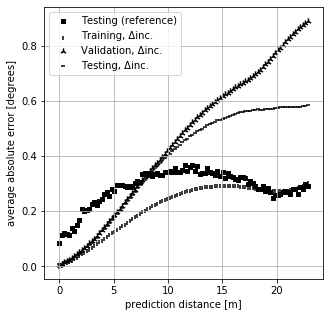

In [24]:
plt.scatter(x,np.average(np.abs(error[1299-86:]), axis=0), c="black",alpha=1,s=12, marker="s", label="Testing (reference)")

#error2 = np.load("errorinc.npy")
error2 = np.load("errorinc2020.npy")

plt.scatter(x,np.average(np.abs(error2[:1039-86]), axis=0), c="black",s=20, marker=3, label="Training, Δinc.")

plt.scatter(x,np.average(np.abs(error2[1039-86:1299-86]), axis=0),c="black",s=40, marker="2", label="Validation, Δinc.")
plt.scatter(x,np.average(np.abs(error2[1299-86:]), axis=0), c="black",s=10,alpha=1, marker="_", label="Testing, Δinc.")

plt.xlabel("prediction distance [m]")
plt.ylabel("average absolute error [degrees]")
plt.grid()

plt.legend()
plt.savefig("averaga_absolute2.pdf", dpi=300,bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

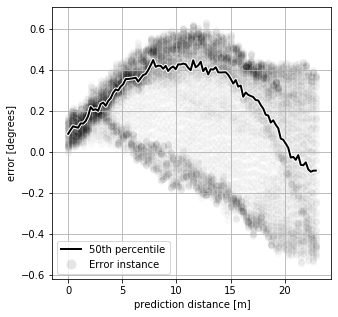

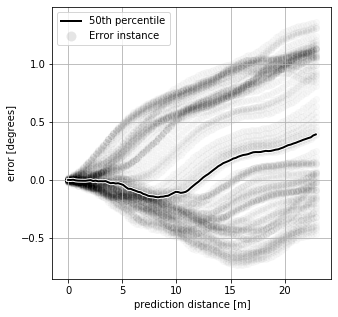

In [25]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='black', lw=2, label='50th percentile'),
                   Line2D([0], [0], marker='o', color='w', label='Error instance',
                          markerfacecolor='black', alpha=0.1, markersize=10)]

#plt.plot(x,error95, linewidth=1, c="#0e2945", label="95th percentile");
plt.plot(x,error50, linewidth=4, c="white",alpha=1,label="50th percentile");
plt.plot(x,error50, linewidth=2, c="black",label="50th percentile");
#plt.plot(x,error5, linewidth=1, c="#0e2945",label="5th percentile");
plt.legend(handles=legend_elements)
plt.grid()
for i in np.rot90(error[1299-86:],4):
    _ = plt.scatter(x,i, alpha=0.02, c="black");
#plt.title("Global error, over Test dataset")
plt.xlabel("prediction distance [m]")
plt.ylabel("error [degrees]")
plt.savefig("errorhair.png", dpi=300,bbox_inches = 'tight',
    pad_inches = 0)
plt.show();




legend_elements = [Line2D([0], [0], color='black', lw=2, label='50th percentile'),
                   Line2D([0], [0], marker='o', color='w', label='Error instance',
                          markerfacecolor='black', alpha=0.1,markersize=10)]
error250 = np.percentile(error2[1299-86:],50,axis=0).flatten()

#plt.plot(x,error95, linewidth=1, c="#0e2945", label="95th percentile");
plt.plot(x,error250, linewidth=4, c="white",alpha=1,label="50th percentile");
plt.plot(x,error250, linewidth=2, c="black",label="50th percentile");
#plt.plot(x,error5, linewidth=1, c="#0e2945",label="5th percentile");
plt.legend(handles=legend_elements)
plt.grid()
for i in np.rot90(error2[1299-86:],4):
    _ = plt.scatter(x,i, alpha=0.02, c="black");
#plt.title("Global error, over Test dataset")
plt.xlabel("prediction distance [m]")
plt.ylabel("error [degrees]")
plt.savefig("errorhair2.png", dpi=300,bbox_inches = 'tight',
    pad_inches = 0)
plt.show();


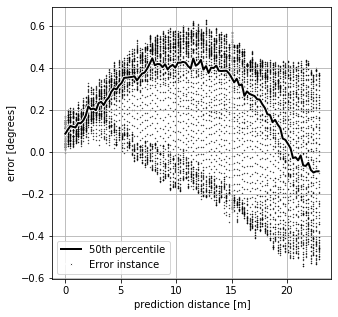

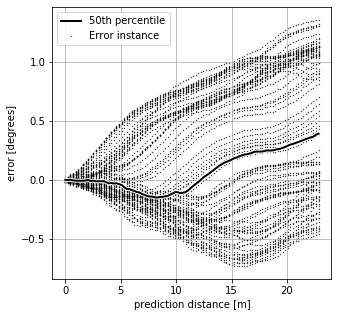

In [26]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='black', lw=2, label='50th percentile'),
                   Line2D([0], [0], marker='o', color='w', label='Error instance',
                          markerfacecolor='black', alpha=1, markersize=2)]

#plt.plot(x,error95, linewidth=1, c="#0e2945", label="95th percentile");
plt.plot(x,error50, linewidth=4, c="white",alpha=1,label="50th percentile");
plt.plot(x,error50, linewidth=2, c="black",label="50th percentile");
#plt.plot(x,error5, linewidth=1, c="#0e2945",label="5th percentile");
plt.legend(handles=legend_elements)
plt.grid()
for i in np.rot90(error[1299-86:],4):
    _ = plt.scatter(x,i, alpha=1,s=0.5,marker=".", c="black");
#plt.title("Global error, over Test dataset")
plt.xlabel("prediction distance [m]")
plt.ylabel("error [degrees]")
plt.savefig("errorhair.png", dpi=300,bbox_inches = 'tight',
    pad_inches = 0)
plt.show();




legend_elements = [Line2D([0], [0], color='black', lw=2, label='50th percentile'),
                   Line2D([0], [0], marker='o', color='w', label='Error instance',
                          markerfacecolor='black', alpha=1,markersize=2)]
error250 = np.percentile(error2[1299-86:],50,axis=0).flatten()

#plt.plot(x,error95, linewidth=1, c="#0e2945", label="95th percentile");
plt.plot(x,error250, linewidth=4, c="white",alpha=1,label="50th percentile");
plt.plot(x,error250, linewidth=2, c="black",label="50th percentile");
#plt.plot(x,error5, linewidth=1, c="#0e2945",label="5th percentile");
plt.legend(handles=legend_elements)
plt.grid()
for i in np.rot90(error2[1299-86:],4):
    _ = plt.scatter(x,i, alpha=1,s=0.5,marker=".", c="black");
#plt.title("Global error, over Test dataset")
plt.xlabel("prediction distance [m]")
plt.ylabel("error [degrees]")
plt.savefig("errorhair2.png", dpi=300,bbox_inches = 'tight',
    pad_inches = 0)
plt.show();


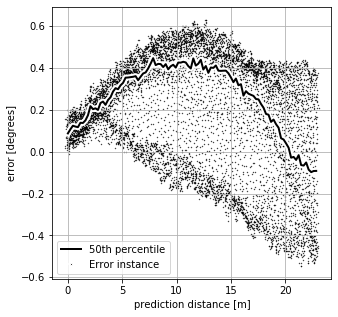

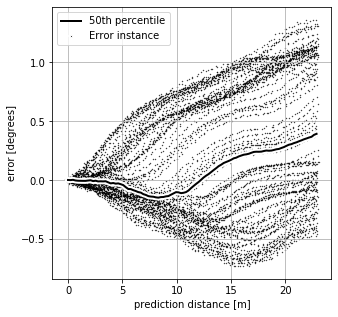

In [27]:
rcParams['figure.figsize'] = 5, 5

def rand_jitter(arr):
    stdev = .004*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, verts=verts, **kwargs)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='black', lw=2, label='50th percentile'),
                   Line2D([0], [0], marker='o', color='w', label='Error instance',
                          markerfacecolor='black', alpha=1, markersize=2)]

#plt.plot(x,error95, linewidth=1, c="#0e2945", label="95th percentile");
plt.plot(x,error50, linewidth=6, c="white",alpha=1,label="50th percentile");
plt.plot(x,error50, linewidth=2, c="black",label="50th percentile");
#plt.plot(x,error5, linewidth=1, c="#0e2945",label="5th percentile");
plt.legend(handles=legend_elements)
plt.grid()
for i in np.rot90(error[1299-86:],4):
    _ = jitter(x,i, alpha=1,s=0.5,marker=".", c="black");
#plt.title("Global error, over Test dataset")
plt.xlabel("prediction distance [m]")
plt.ylabel("error [degrees]")
plt.savefig("errorhair.pdf", dpi=300,bbox_inches = 'tight',
    pad_inches = 0)
plt.show();




legend_elements = [Line2D([0], [0], color='black', lw=2, label='50th percentile'),
                   Line2D([0], [0], marker='o', color='w', label='Error instance',
                          markerfacecolor='black', alpha=1,markersize=2)]
error250 = np.percentile(error2[1299-86:],50,axis=0).flatten()

#plt.plot(x,error95, linewidth=1, c="#0e2945", label="95th percentile");
plt.plot(x,error250, linewidth=6, c="white",alpha=1,label="50th percentile");
plt.plot(x,error250, linewidth=2, c="black",label="50th percentile");
#plt.plot(x,error5, linewidth=1, c="#0e2945",label="5th percentile");
plt.legend(handles=legend_elements)
plt.grid()
for i in np.rot90(error2[1299-86:],4):
    _ = jitter(x,i, alpha=1,s=0.5,marker=".", c="black");
#plt.title("Global error, over Test dataset")
plt.xlabel("prediction distance [m]")
plt.ylabel("error [degrees]")
plt.savefig("errorhair2.pdf", dpi=300,bbox_inches = 'tight',
    pad_inches = 0)
plt.show();